# NNIA 18/19 Project 4:  Optimization \& Recurrent Neural Networks

In [181]:
# imports
%matplotlib notebook
import re
import math
import random
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['figure.figsize'] = (12.0, 8.0)

In this task, we will get familiar with various optimization methods such as **Vanilla Gradient Descent** (GD), [**Gradient Descent with Momentum**](https://www.tensorflow.org/api_docs/python/tf/train/MomentumOptimizer), [**RMSProp**](https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer) and [**AdaGrad**](https://www.tensorflow.org/api_docs/python/tf/train/AdagradOptimizer) by implementing them in TensorFlow and *visualizing* the path (convergence) towards minima using [Matplotlib 3D/Contour plots](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html).

**3D Loss Surface**

For the following exercises we assume that the surface of the general **loss** we want to minimize is given by a function `z`. On this function, we apply different optimization methods and want to visualize their stepwise improvements. `z` is defined as:

$$ term1 = \frac{2}{\sqrt{(2\pi \alpha_{1}^{2})^{2}}} * \exp{\left(- \left[ \frac{(x-\mu_1)^2}{(\frac{\alpha {1}}{2})^2} + \frac{(y-\mu_1)^2}{(\alpha_1)^2}     \right] \right)} $$

$$ term2 = \frac{1}{\sqrt{(2\pi \alpha_{2}^{2})^{2}}} * \exp{\left(- \left[ \frac{(x-\mu_2)^2 + (y-\mu_2)^2}{(\alpha_2)^2} \right] \right)} $$

$$ term3 = \frac{1}{20} * \left(x^2  + xy + y^2 \right) $$ <br>

$$ z_{\alpha, \mu}(x, y) = term1 - term2 + term3 $$

<IPython.core.display.Javascript object>


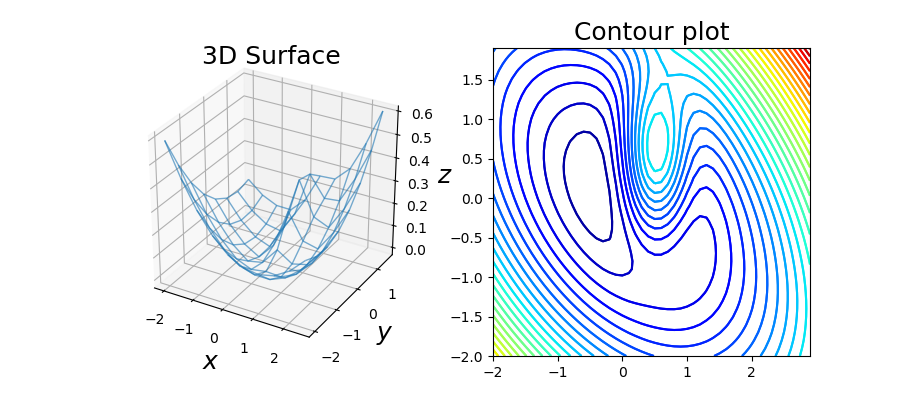

In [182]:
# %matplotlib inline

# params of our error surface `z`
alpha_1 = 1.0
alpha_2 = 2.0
mu_1 = 0.5
mu_2 = 0.0
range_x, range_y = np.arange(-2.0, 3.0, 0.5), np.arange(-2.0, 2.0, 0.5)

def func_z(X, Y):
    """
    function definition of our 3D error surface
    """
    exp_input_1 = -1 * ((((X - mu_1)**2) / (alpha_1/2)**2) + (((Y - mu_1)**2)/(alpha_1**2)))
    term_1 = 2/np.sqrt((2 * np.pi * alpha_1**2)**2) * np.exp(exp_input_1)
    
    exp_input_2 = -1 * ( ((X - mu_2)**2 + (Y - mu_2)**2) / alpha_2**2)
    term_2 = 1/np.sqrt((2 * np.pi * alpha_2**2)**2) * np.exp(exp_input_2)
    
    term_3 = 1/20 * (X**2 + X * Y + Y**2)
    
    return term_1 - term_2 + term_3

# x,y values for `Wireframe` plot
x_wireframe, y_wireframe = np.arange(-2.0, 3.0, 0.5), np.arange(-2.0, 2.0, 0.5)

# x,y values for `Contour` plot
x_contour, y_contour = np.arange(-2.0, 3.0, 0.1), np.arange(-2.0, 2.0, 0.1)

# Following code implements the plotting the Error Surface
X_sparse, Y_sparse = np.meshgrid(x_wireframe, y_wireframe)
Z_sparse = func_z(X_sparse, Y_sparse)

X_dense, Y_dense = np.meshgrid(x_contour, y_contour)
Z_dense = func_z(X_dense, Y_dense)

fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)

ax1.plot_wireframe(X_sparse, Y_sparse, Z_sparse, linewidth=1, cmap=cm.jet, zorder=1, alpha=0.6)
ax2.contour(X_dense, Y_dense, Z_dense, 32,  cmap=cm.jet)

ax1.set_xlabel(r'$x$',fontsize=18)
ax1.set_ylabel(r'$y$',fontsize=18)
ax1.set_zlabel(r'$z$',fontsize=18)
ax1.set_title('3D Surface', fontsize=18)

ax2.contour(X_dense, Y_dense, Z_dense, 32,  cmap=cm.jet)
ax2.autoscale(False)
ax2.set_title('Contour plot', fontsize=18)

plt.show()

### 1.1 Error Implementation with Tensorflow

In [183]:
# The following variables  will come in handy when implementing the error surface using tensorflow functions below
tf_x, tf_y, tf_z, = None, None, None
tf_reinit_x, tf_reinit_y = None, None
session = None

def problem_3d(start_x, start_y):
    global session
    global tf_x, tf_y, tf_z
    global tf_reinit_x, tf_reinit_y
    
    tf.reset_default_graph()
    session = tf.InteractiveSession()

    with tf.variable_scope('opt'):
        tf_x = tf.get_variable('x', initializer=tf.constant(start_x, shape=None, dtype=tf.float32))
        tf_y = tf.get_variable('y', initializer=tf.constant(start_y, shape=None, dtype=tf.float32))

    with tf.variable_scope('opt', reuse=True):
        tf_reinit_x = tf.assign(tf.get_variable('x'), start_x)
        tf_reinit_y = tf.assign(tf.get_variable('y'), start_y)
        
        
    
    # TODO Implement 3D error surface using the above defined variables
    alpha_1 = tf.constant(1.0, dtype=tf.float32)
    alpha_2 = tf.constant(2.0, dtype=tf.float32)
    mu_1 = tf.constant(0.5, dtype=tf.float32)
    mu_2 = tf.constant(0.0, dtype=tf.float32)
    pi = tf.constant(math.pi, dtype=tf.float32)
    c1 = tf.divide(2.0, tf.sqrt(tf.square(tf.multiply(2.0, tf.multiply(pi, tf.square(alpha_1))))))
    c2 = tf.divide(1.0, tf.sqrt(tf.square(tf.multiply(2.0, tf.multiply(pi, tf.square(alpha_2))))))
    e1 = tf.exp(-tf.add(tf.divide(tf.square(tf.subtract(tf_x,mu_1)),tf.square(tf.divide(alpha_1,2.0))),tf.divide(tf.square(tf.subtract(tf_y,mu_1)),tf.square(alpha_1))))
    e2 = tf.exp(-tf.add(tf.divide(tf.square(tf.subtract(tf_x,mu_2)),tf.square(alpha_2)),tf.divide(tf.square(tf.subtract(tf_y,mu_2)),tf.square(alpha_2))))
    term_1 = tf.multiply(c1, e1)
    term_2 = tf.multiply(c2, e2)
    term_3 = tf.divide(tf.add(tf.add(tf.square(tf_x),tf.multiply(tf_x,tf_y)),tf.square(tf_y)),20.0)
    tf_z = term_1 - term_2 + term_3
    
    #tf_z = tf_term_1 - tf_term_2 + tf_term_3
    

In [184]:
class GradientDescentMomentumOptimizer():
    
    def __init__(self, learning_rate, alpha):

        with tf.variable_scope('gdm_opt'):
            self.learning_rate = tf.get_variable('lr', initializer=tf.constant(learning_rate, shape=[], dtype=tf.float32))
            self.alpha = tf.get_variable('alpha', initializer=tf.constant(alpha, shape=None, dtype=tf.float32))
            self.v = tf.get_variable('v', initializer=tf.constant([0, 0], shape=[2, 1], dtype=tf.float32))

        # input 
        self.input_x = tf.placeholder("float", [])
        self.input_y = tf.placeholder("float", [])

        # optimized outputs
        self.out_x = None
        self.out_y = None  

        # gradients
        self.grads = None

        # objective to minimize      
        self.objective = None
        
    def minimize(self, objective):
        self.objective = objective
        return self.optimization_step()

    def update(self, new_x, new_y, new_v):

        with tf.variable_scope('opt', reuse=True):
            tf_reinit_x = tf.assign(tf.get_variable('x'), new_x[0])
            tf_reinit_y = tf.assign(tf.get_variable('y'), new_y[0])

        with tf.variable_scope('gdm_opt', reuse=True):
            set_v =  tf.assign(tf.get_variable('v'), new_v)
            
        return tf_reinit_x, tf_reinit_y, set_v

    def optimization_step(self):
        
        global tf_x, tf_y   
        
        #TODO: Implement this function returning the updated positions into self.out_x, self.out_y
        self.grads = tf.gradients(xs=[tf_x, tf_y], ys=self.objective)
        self.v = tf.multiply(self.alpha, self.v) - tf.multiply(self.learning_rate, self.grads[0])
        tf_x = tf_x + self.v
        self.out_x = tf_x[1]
        self.v = tf.multiply(self.alpha, self.v) - tf.multiply(self.learning_rate, self.grads[1])
        tf_y = tf_y + self.v
        self.out_y = tf_y[1]
        
        return self.out_x, self.out_y

In [185]:
# starting position
start_x, start_y = 0.55, 0.6
n_steps = 60

problem_3d(start_x,start_y)

lr = 0.2
alpha = 0.9

optimizer = GradientDescentMomentumOptimizer(lr, alpha)
opt_step = optimizer.minimize(objective=tf_z)

# initialize variables
session.run(tf.global_variables_initializer())

# set initial values
session.run([tf_reinit_x, tf_reinit_y])

# keep track of all steps
opt_gd_points_x, opt_gd_points_y, opt_gd_points_z = [],[],[]

# fill in the initial position
opt_gd_points_x.append(start_x)
opt_gd_points_y.append(start_y)
opt_gd_points_z.append(func_z(start_x,start_y))

x, y = [start_x], [start_y]

print('Momentum GD Optimization started')
for step in range(n_steps):
    
    # perform optimization step
    x, y, z, v, cur_gradient, _ = session.run([optimizer.out_x, optimizer.out_y, tf_z, optimizer.v, optimizer.grads, opt_step], feed_dict={optimizer.input_x: x[0], optimizer.input_y: y[0]}) 

    # update the function
    session.run([optimizer.update(x, y, v)])
    
    opt_gd_points_x.append(x[0])
    opt_gd_points_y.append(y[0])
    opt_gd_points_z.append(func_z(x[0], y[0]))
    
    if step % 10 == 0:
        print("Optimization step {} - minimized value: {}".format(step, z))

Momentum GD Optimization started
Optimization step 0 - minimized value: 0.32791638374328613
Optimization step 10 - minimized value: 0.22606691718101501
Optimization step 20 - minimized value: 0.17329680919647217
Optimization step 30 - minimized value: 0.14570081233978271
Optimization step 40 - minimized value: 0.11822110414505005
Optimization step 50 - minimized value: 0.09377589076757431


<IPython.core.display.Javascript object>


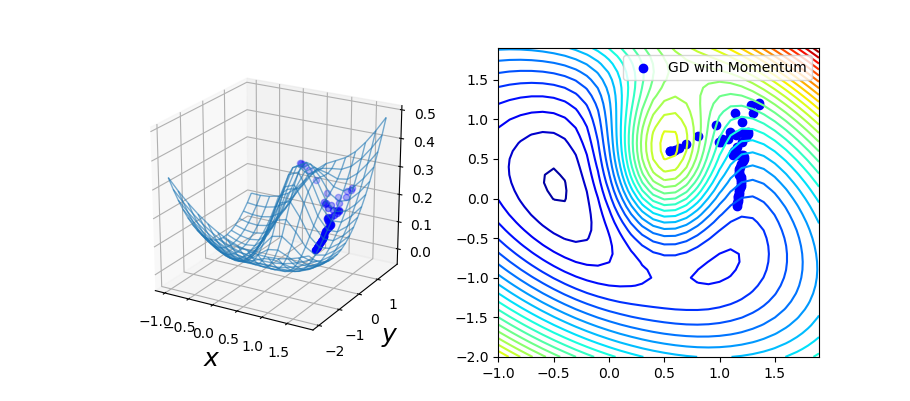

In [186]:
range_x,range_y = np.arange(-1.0,2.0,0.2), np.arange(-2.0,2.0,0.2)
X_lowres, Y_lowres = np.meshgrid(range_x, range_y)
Z_lowres = func_z(X_lowres,Y_lowres)

range_x,range_y = np.arange(-1.0,2.0,0.1), np.arange(-2.0,2.0,0.1)
X_hires, Y_hires = np.meshgrid(range_x, range_y)
Z_hires = func_z(X_hires,Y_hires)

fig = plt.figure(figsize=(9,4))

epsilon = 0.0
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)

# plot
ax1.plot_wireframe(X_lowres, Y_lowres, Z_lowres, linewidth=1, cmap=cm.jet, zorder=1, alpha=0.6)
ax2.contour(X_hires, Y_hires, Z_hires, 32,  cmap=cm.jet)
ax2.autoscale(False)

for idx, (x,y,z) in enumerate(zip(opt_gd_points_x, opt_gd_points_y, opt_gd_points_z)):
    if idx != len(opt_gd_points_x)-1:
        ax1.scatter(x,y,z + epsilon , color='blue', alpha=(idx+10)/(n_steps+10.0), zorder=100)
        ax2.scatter(np.asarray(x),np.asarray(y) , color='blue')
    else:
        ax1.scatter(x,y,z + epsilon , color='blue', alpha=(idx+10)/(n_steps+10.0), label='GD with Momentum', zorder=100)
        ax2.scatter(x,y, color='blue', label='GD with Momentum')

ax1.set_xlabel(r'$x$', fontsize=18)
ax1.set_ylabel(r'$y$', fontsize=18)
plt.legend()
plt.show()


lr: 0.2 alpha: 0.0
Momentum GD Optimization started
Optimization step 0 - minimized value: 0.32791638374328613
Optimization step 10 - minimized value: 0.18757379055023193
Optimization step 20 - minimized value: 0.1015080064535141
Optimization step 30 - minimized value: 0.08168408274650574
Optimization step 40 - minimized value: 0.06764581799507141
Optimization step 50 - minimized value: 0.05773647129535675


<IPython.core.display.Javascript object>


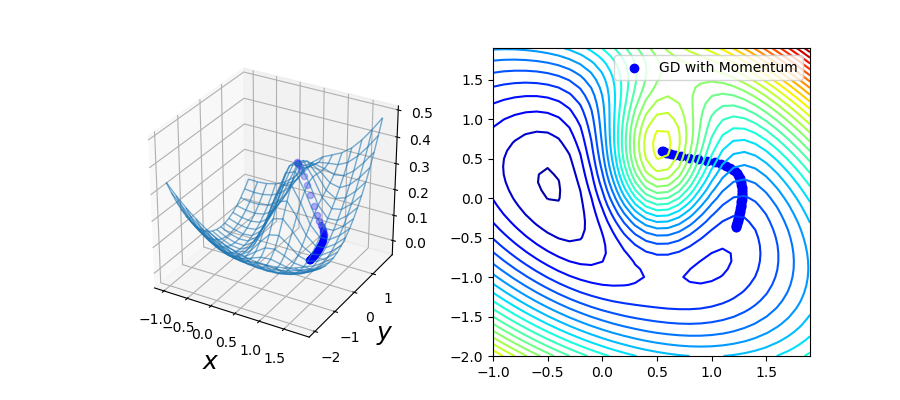


lr: 0.2 alpha: 0.3
Momentum GD Optimization started
Optimization step 0 - minimized value: 0.32791638374328613
Optimization step 10 - minimized value: 0.21326014399528503
Optimization step 20 - minimized value: 0.12918515503406525
Optimization step 30 - minimized value: 0.10333718359470367
Optimization step 40 - minimized value: 0.08286167681217194
Optimization step 50 - minimized value: 0.06754463165998459


<IPython.core.display.Javascript object>


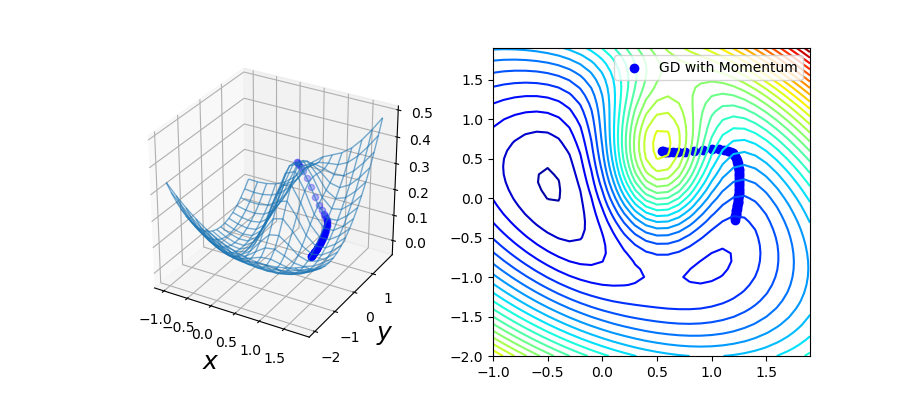


lr: 0.2 alpha: 0.6
Momentum GD Optimization started
Optimization step 0 - minimized value: 0.32791638374328613
Optimization step 10 - minimized value: 0.20214778184890747
Optimization step 20 - minimized value: 0.1548042744398117
Optimization step 30 - minimized value: 0.12659430503845215
Optimization step 40 - minimized value: 0.1014215350151062
Optimization step 50 - minimized value: 0.08066067099571228


<IPython.core.display.Javascript object>


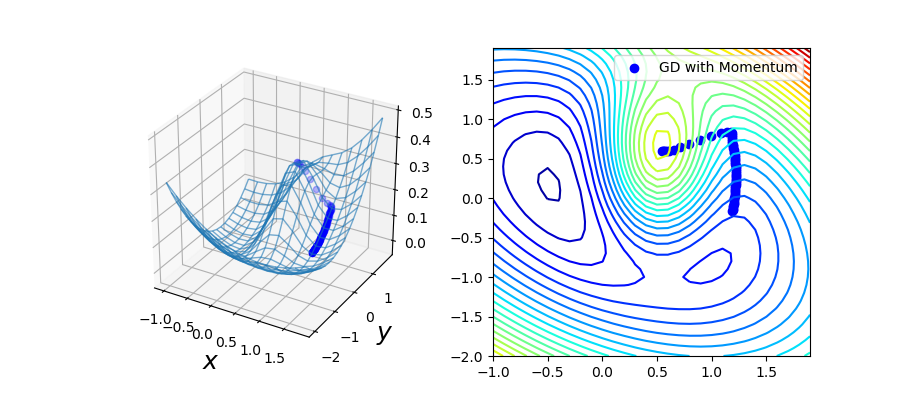


lr: 0.2 alpha: 0.9
Momentum GD Optimization started
Optimization step 0 - minimized value: 0.32791638374328613
Optimization step 10 - minimized value: 0.22606691718101501
Optimization step 20 - minimized value: 0.17329680919647217
Optimization step 30 - minimized value: 0.14570081233978271
Optimization step 40 - minimized value: 0.11822110414505005
Optimization step 50 - minimized value: 0.09377589076757431


<IPython.core.display.Javascript object>


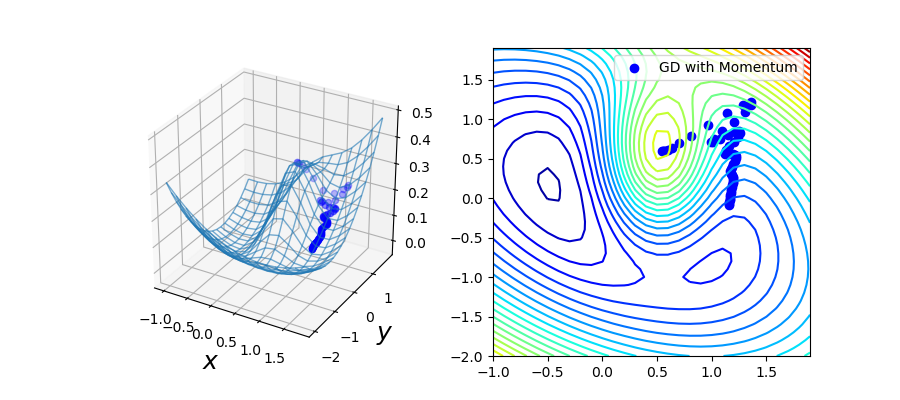


lr: 0.4 alpha: 0.0
Momentum GD Optimization started
Optimization step 0 - minimized value: 0.32791638374328613
Optimization step 10 - minimized value: 0.10305021703243256
Optimization step 20 - minimized value: 0.06833378970623016
Optimization step 30 - minimized value: 0.051104865968227386
Optimization step 40 - minimized value: 0.043095994740724564
Optimization step 50 - minimized value: 0.03950715810060501


<IPython.core.display.Javascript object>


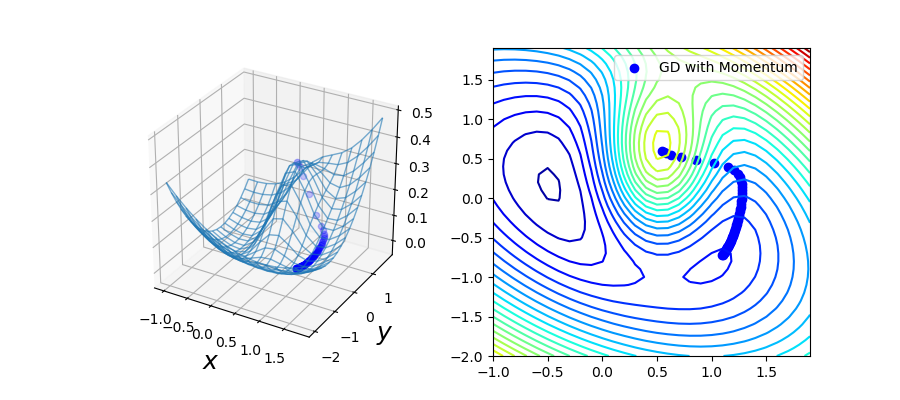


lr: 0.4 alpha: 0.3
Momentum GD Optimization started
Optimization step 0 - minimized value: 0.32791638374328613
Optimization step 10 - minimized value: 0.1310579776763916
Optimization step 20 - minimized value: 0.0839242935180664
Optimization step 30 - minimized value: 0.0570361465215683
Optimization step 40 - minimized value: 0.044507794082164764
Optimization step 50 - minimized value: 0.03945323824882507


<IPython.core.display.Javascript object>


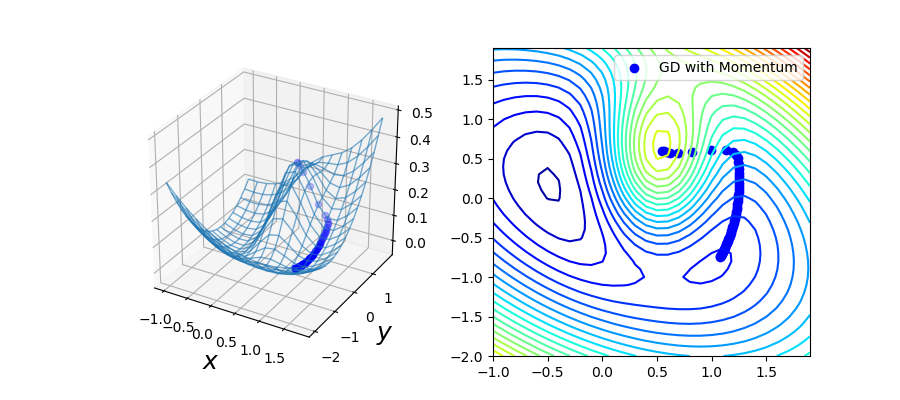


lr: 0.4 alpha: 0.6
Momentum GD Optimization started
Optimization step 0 - minimized value: 0.32791638374328613
Optimization step 10 - minimized value: 0.15688462555408478
Optimization step 20 - minimized value: 0.10292597115039825
Optimization step 30 - minimized value: 0.06548503041267395
Optimization step 40 - minimized value: 0.04638485610485077
Optimization step 50 - minimized value: 0.039228178560733795


<IPython.core.display.Javascript object>


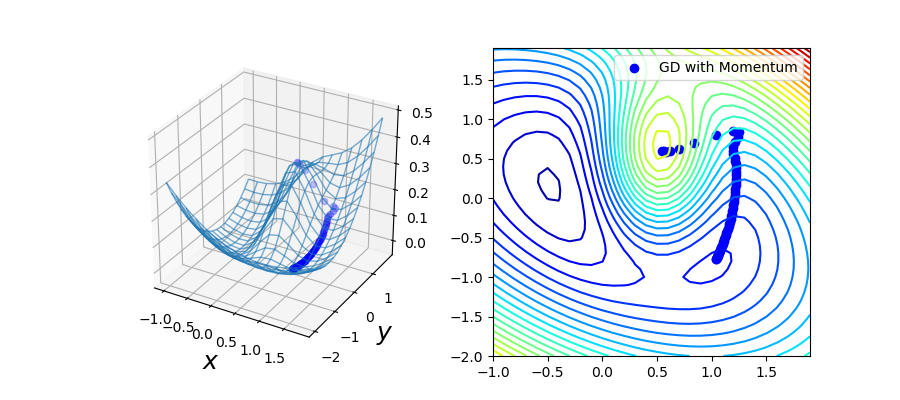


lr: 0.4 alpha: 0.9
Momentum GD Optimization started
Optimization step 0 - minimized value: 0.32791638374328613
Optimization step 10 - minimized value: 0.170870840549469
Optimization step 20 - minimized value: 0.12351904809474945
Optimization step 30 - minimized value: 0.07187989354133606
Optimization step 40 - minimized value: 0.046150241047143936
Optimization step 50 - minimized value: 0.038342736661434174


<IPython.core.display.Javascript object>


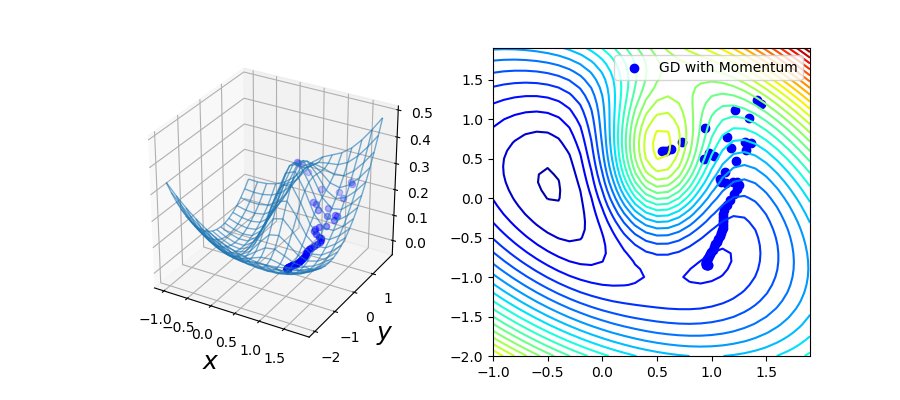


lr: 0.6 alpha: 0.0
Momentum GD Optimization started
Optimization step 0 - minimized value: 0.32791638374328613
Optimization step 10 - minimized value: 0.08382238447666168
Optimization step 20 - minimized value: 0.051312439143657684
Optimization step 30 - minimized value: 0.04095184803009033
Optimization step 40 - minimized value: 0.037902507930994034
Optimization step 50 - minimized value: 0.03700651973485947


<IPython.core.display.Javascript object>


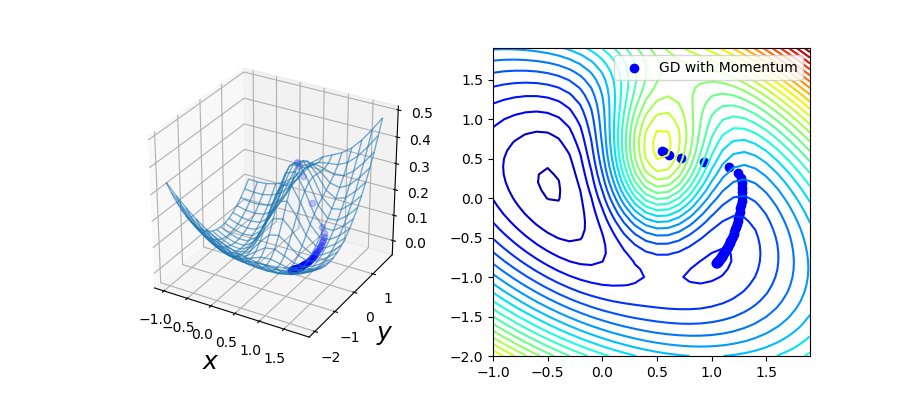


lr: 0.6 alpha: 0.3
Momentum GD Optimization started
Optimization step 0 - minimized value: 0.32791638374328613
Optimization step 10 - minimized value: 0.106332927942276
Optimization step 20 - minimized value: 0.05737576261162758
Optimization step 30 - minimized value: 0.04136962071061134
Optimization step 40 - minimized value: 0.03756646066904068
Optimization step 50 - minimized value: 0.03679628670215607


<IPython.core.display.Javascript object>


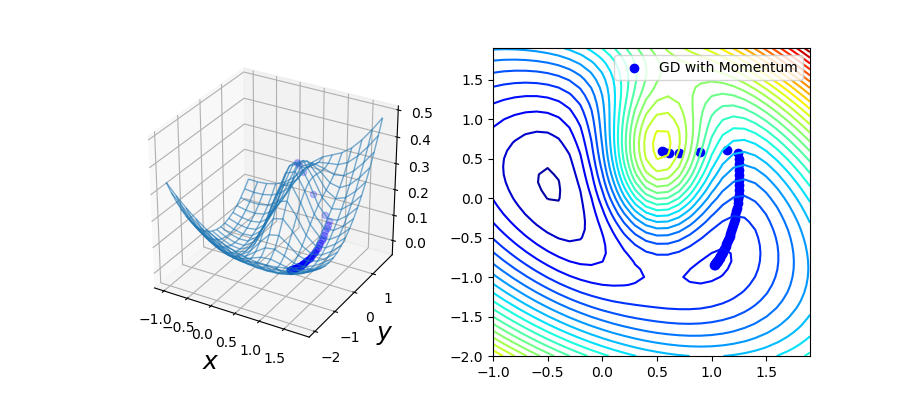


lr: 0.6 alpha: 0.6
Momentum GD Optimization started
Optimization step 0 - minimized value: 0.32791638374328613
Optimization step 10 - minimized value: 0.1302051544189453
Optimization step 20 - minimized value: 0.06600011885166168
Optimization step 30 - minimized value: 0.04176482930779457
Optimization step 40 - minimized value: 0.0371578224003315
Optimization step 50 - minimized value: 0.03665706142783165


<IPython.core.display.Javascript object>


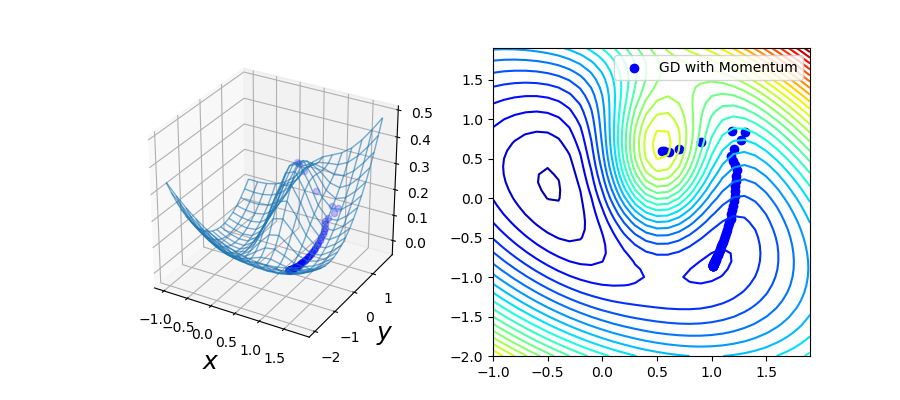


lr: 0.6 alpha: 0.9
Momentum GD Optimization started
Optimization step 0 - minimized value: 0.32791638374328613
Optimization step 10 - minimized value: 0.19320844113826752
Optimization step 20 - minimized value: 0.06596632301807404
Optimization step 30 - minimized value: 0.03977401554584503
Optimization step 40 - minimized value: 0.03718225657939911
Optimization step 50 - minimized value: 0.036654409021139145


<IPython.core.display.Javascript object>


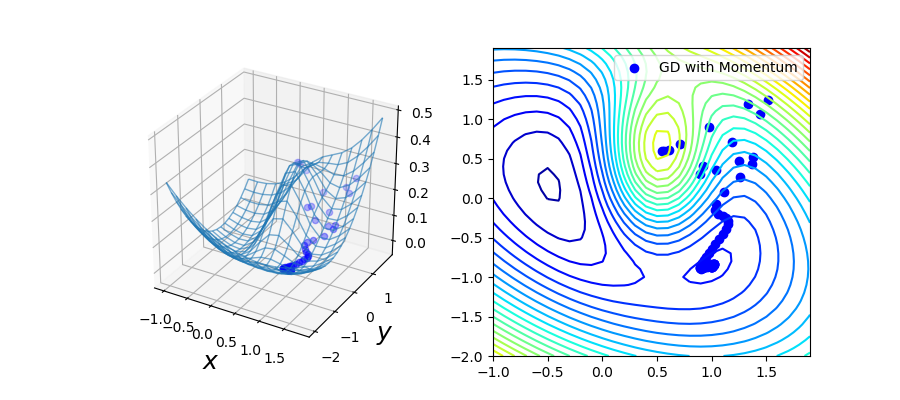

In [224]:
lr_lst = np.linspace(0.2, 0.6, 3)
alpha_lst = np.linspace(0.0,0.9,4)

for lr in lr_lst:
    for alpha in alpha_lst:
        # starting position
        start_x, start_y = 0.55, 0.6
        n_steps = 60

        problem_3d(start_x,start_y)

        #lr = 0.1
        #alpha = 0#.9

        optimizer = GradientDescentMomentumOptimizer(lr, alpha)
        opt_step = optimizer.minimize(objective=tf_z)

        # initialize variables
        session.run(tf.global_variables_initializer())

        # set initial values
        session.run([tf_reinit_x, tf_reinit_y])

        # keep track of all steps
        opt_gd_points_x, opt_gd_points_y, opt_gd_points_z = [],[],[]

        # fill in the initial position
        opt_gd_points_x.append(start_x)
        opt_gd_points_y.append(start_y)
        opt_gd_points_z.append(func_z(start_x,start_y))

        x, y = [start_x], [start_y]
        
        print("\nlr: {} alpha: {}" .format(lr, alpha))

        print('Momentum GD Optimization started')
        for step in range(n_steps):

            # perform optimization step
            x, y, z, v, cur_gradient, _ = session.run([optimizer.out_x, optimizer.out_y, tf_z, optimizer.v, optimizer.grads, opt_step], feed_dict={optimizer.input_x: x[0], optimizer.input_y: y[0]}) 

            # update the function
            session.run([optimizer.update(x, y, v)])

            opt_gd_points_x.append(x[0])
            opt_gd_points_y.append(y[0])
            opt_gd_points_z.append(func_z(x[0], y[0]))

            if step % 10 == 0:
                print("Optimization step {} - minimized value: {}".format(step, z))

        range_x,range_y = np.arange(-1.0,2.0,0.2), np.arange(-2.0,2.0,0.2)
        X_lowres, Y_lowres = np.meshgrid(range_x, range_y)
        Z_lowres = func_z(X_lowres,Y_lowres)

        range_x,range_y = np.arange(-1.0,2.0,0.1), np.arange(-2.0,2.0,0.1)
        X_hires, Y_hires = np.meshgrid(range_x, range_y)
        Z_hires = func_z(X_hires,Y_hires)

        fig = plt.figure(figsize=(9,4))

        epsilon = 0.0
        ax1 = fig.add_subplot(121,projection='3d')
        ax2 = fig.add_subplot(122)

        # plot
        ax1.plot_wireframe(X_lowres, Y_lowres, Z_lowres, linewidth=1, cmap=cm.jet, zorder=1, alpha=0.6)
        ax2.contour(X_hires, Y_hires, Z_hires, 32,  cmap=cm.jet)
        ax2.autoscale(False)

        for idx, (x,y,z) in enumerate(zip(opt_gd_points_x, opt_gd_points_y, opt_gd_points_z)):
            if idx != len(opt_gd_points_x)-1:
                ax1.scatter(x,y,z + epsilon , color='blue', alpha=(idx+10)/(n_steps+10.0), zorder=100)
                ax2.scatter(np.asarray(x),np.asarray(y) , color='blue')
            else:
                ax1.scatter(x,y,z + epsilon , color='blue', alpha=(idx+10)/(n_steps+10.0), label='GD with Momentum', zorder=100)
                ax2.scatter(x,y, color='blue', label='GD with Momentum')

        ax1.set_xlabel(r'$x$', fontsize=18)
        ax1.set_ylabel(r'$y$', fontsize=18)
        plt.legend()
        plt.show()

### 1.3 Using Tensorflow's Optimizer Implementations

In [65]:
# starting position
start_x, start_y = 0.55, 0.6
n_steps = 60

# Write code to define GD, Momentum, RMSProp and Adagrad implementations on tf_z global variable defined by problem_3d

with tf.variable_scope('gd', reuse=tf.AUTO_REUSE):
    # TODO: Define Gradient Descent Optimizer with learning rate = 0.1
    tf_optimize_z = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(tf_z)

with tf.variable_scope('momentum', reuse=tf.AUTO_REUSE):
    # TODO: Define Gradient Descent with Nestrov's Momentum Optimizer with learning rate = 0.1 and momentum = 0.9
    tf_mom_optimize_z = tf.train.MomentumOptimizer(learning_rate=0.1, momentum=0.9, use_nesterov=True).minimize(tf_z)
    
with tf.variable_scope('rmsprop', reuse=tf.AUTO_REUSE):
    # TODO: Define RMSProp with learning rate = 0.1
    tf_rms_optimize_z = tf.train.RMSPropOptimizer(learning_rate=0.1).minimize(tf_z)
    
with tf.variable_scope('adagrad', reuse=tf.AUTO_REUSE):
    # TODO: Define Adagrad Optimizer with learning rate = 0.1
    tf_ada_optimize_z = tf.train.AdagradOptimizer(learning_rate=0.1).minimize(tf_z)
    

Vanilla GD Optimization started
Vanilla GD Optimization finished
Momentum Optimization started
Momentum Optimization finished
RMSProp Optimization started
RMSProp Optimization finished
Adagrad Optimization started
Adagrad Optimization finished


<IPython.core.display.Javascript object>


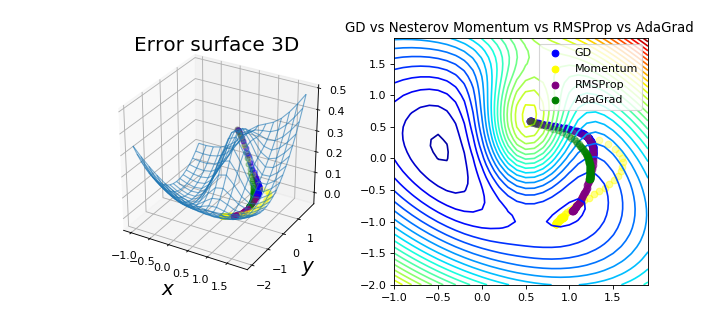

In [66]:
session.run(tf.global_variables_initializer())

# Run vanilla GD on Error Surface
session.run([tf_reinit_x, tf_reinit_y])

opt_gd_points_x, opt_gd_points_y, opt_gd_points_z = [],[],[]
opt_gd_points_x.append(start_x)
opt_gd_points_y.append(start_y)
opt_gd_points_z.append(func_z(start_x,start_y))

print('Vanilla GD Optimization started')
for step in range(n_steps):
    session.run(tf_optimize_z)
    x, y, z = session.run([tf_x, tf_y, tf_z])    
    opt_gd_points_x.append(x)
    opt_gd_points_y.append(y)
    opt_gd_points_z.append(z)
print('Vanilla GD Optimization finished')


# Run Nestrov's Momentum GD on Error Surface
session.run([tf_reinit_x, tf_reinit_y])

opt_mom_points_x, opt_mom_points_y, opt_mom_points_z = [],[],[]
opt_mom_points_x.append(start_x)
opt_mom_points_y.append(start_y)
opt_mom_points_z.append(func_z(start_x,start_y))


print("Momentum Optimization started")
for step in range(n_steps):
    session.run(tf_mom_optimize_z)
    x, y, z = session.run([tf_x, tf_y, tf_z])    
    opt_mom_points_x.append(x)
    opt_mom_points_y.append(y)
    opt_mom_points_z.append(z)
print('Momentum Optimization finished')
    
# RMSProp
session.run([tf_reinit_x, tf_reinit_y])

opt_rms_points_x, opt_rms_points_y, opt_rms_points_z = [],[],[]
opt_rms_points_x.append(start_x)
opt_rms_points_y.append(start_y)
opt_rms_points_z.append(func_z(start_x,start_y))

print('RMSProp Optimization started')
for step in range(n_steps):
    session.run(tf_rms_optimize_z)
    x, y, z = session.run([tf_x, tf_y, tf_z])    
    opt_rms_points_x.append(x)
    opt_rms_points_y.append(y)
    opt_rms_points_z.append(z)
print('RMSProp Optimization finished')


# Run AdaGrad on Error Surface
session.run([tf_reinit_x, tf_reinit_y])

opt_ada_points_x, opt_ada_points_y, opt_ada_points_z = [],[],[]
opt_ada_points_x.append(start_x)
opt_ada_points_y.append(start_y)
opt_ada_points_z.append(func_z(start_x,start_y))


print('Adagrad Optimization started')
for step in range(n_steps):
    session.run(tf_ada_optimize_z)
    x, y, z = session.run([tf_x, tf_y, tf_z])    
    opt_ada_points_x.append(x)
    opt_ada_points_y.append(y)
    opt_ada_points_z.append(z)
print('Adagrad Optimization finished')

    
range_x,range_y = np.arange(-1.0,2.0,0.2), np.arange(-2.0,2.0,0.2)
X_lowres, Y_lowres = np.meshgrid(range_x, range_y)
Z_lowres = func_z(X_lowres,Y_lowres)

range_x,range_y = np.arange(-1.0,2.0,0.1), np.arange(-2.0,2.0,0.1)
X_hires, Y_hires = np.meshgrid(range_x, range_y)
Z_hires = func_z(X_hires,Y_hires)

# Subplots visualizing the minimization steps

fig = plt.figure(figsize=(9,4))

epsilon = 0.0
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)

# plot
ax1.plot_wireframe(X_lowres, Y_lowres, Z_lowres, linewidth=1, cmap=cm.jet, zorder=1, alpha=0.6)
ax2.contour(X_hires, Y_hires, Z_hires, 32,  cmap=cm.jet)
ax2.autoscale(False)

# vanilla GD
for idx, (x,y,z) in enumerate(zip(opt_gd_points_x, opt_gd_points_y, opt_gd_points_z)):
    if idx != len(opt_gd_points_x)-1:
        ax1.scatter(x,y,z + epsilon , color='blue', alpha=(idx+10)/(n_steps+10.0), zorder=100)
        ax2.scatter(np.asarray(x),np.asarray(y) , color='blue')
    else:
        ax1.scatter(x,y,z + epsilon , color='blue', alpha=(idx+10)/(n_steps+10.0), label='GD', zorder=100)
        ax2.scatter(x,y, color='blue', label='GD')

# GD with momentum
for idx, (x,y,z) in enumerate(zip(opt_mom_points_x, opt_mom_points_y, opt_mom_points_z)):
    if idx != len(opt_mom_points_x)-1:
        ax1.scatter(x,y , z + epsilon , color='yellow', alpha=(idx+10)/(n_steps+10.0), zorder=100)
        ax2.scatter(x,y , color='yellow', alpha=(idx+10)/(n_steps+10.0))
    else:
        ax1.scatter(x,y,z + epsilon , color='yellow', alpha=(idx+10)/(n_steps+10.0), label='Momentum', zorder=100)
        ax2.scatter(x,y, color='yellow', alpha=(idx+10)/(n_steps+10.0), label='Momentum')

# RMSProp
for idx, (x,y,z) in enumerate(zip(opt_rms_points_x, opt_rms_points_y, opt_rms_points_z)):
    if idx != len(opt_rms_points_x)-1:
        ax1.scatter(x,y,z + epsilon , color='purple', alpha=(idx+10)/(n_steps+10.0), zorder=100)
        ax2.scatter(x,y , color='purple', alpha=(idx+10)/(n_steps+10.0))
    else:
        ax1.scatter(x,y,z + epsilon , color='purple', alpha=(idx+10)/(n_steps+10.0), label='RMSProp', zorder=100)
        ax2.scatter(x,y, color='purple', alpha=(idx+10)/(n_steps+10.0), label='RMSProp')
        
# AdaGrad
for idx, (x,y,z) in enumerate(zip(opt_ada_points_x, opt_ada_points_y, opt_ada_points_z)):
    if idx != len(opt_ada_points_x)-1:
        ax1.scatter(x,y,z + epsilon , color='green', alpha=(idx+10)/(n_steps+10.0), zorder=100)
        ax2.scatter(x,y , color='green', alpha=(idx+10)/(n_steps+10.0), zorder=100)
    else:
        ax1.scatter(x,y,z + epsilon , color='green', alpha=(idx+10)/(n_steps+10.0), label='AdaGrad', zorder=100)
        ax2.scatter(x,y,color='green', alpha=(idx+10)/(n_steps+10.0), label='AdaGrad', zorder=100)

ax1.set_xlabel(r'$x$', fontsize=18)
ax1.set_ylabel(r'$y$', fontsize=18)
ax1.set_title("Error surface 3D", fontsize=18)
ax2.set_title('GD vs Nesterov Momentum vs RMSProp vs AdaGrad ', fontsize=12)
plt.legend()
plt.show()

In [67]:
print("\nSGD:",opt_gd_points_z)
print("\nMomentum:",opt_mom_points_z)
print("\nRMSProp:",opt_rms_points_z)
print("\nAdaGrad:",opt_ada_points_z)


SGD: [0.3279163883810402, 0.32768443, 0.3273814, 0.3269757, 0.3264204, 0.32564628, 0.324552, 0.32299107, 0.32075638, 0.31756386, 0.31304246, 0.30674222, 0.2981816, 0.28695592, 0.27291197, 0.25633833, 0.2380572, 0.21929546, 0.20134422, 0.18519187, 0.17133927, 0.15984227, 0.15047532, 0.14289466, 0.13674577, 0.13171515, 0.12754661, 0.12403931, 0.12103947, 0.11843054, 0.11612466, 0.11405556, 0.11217311, 0.11043923, 0.10882496, 0.10730794, 0.10587105, 0.10450089, 0.10318706, 0.10192141, 0.100697435, 0.099510044, 0.098355114, 0.09722938, 0.09613015, 0.09505529, 0.094003014, 0.09297186, 0.09196065, 0.09096834, 0.089994095, 0.08903717, 0.08809699, 0.087172985, 0.08626469, 0.085371695, 0.08449365, 0.083630204, 0.08278107, 0.08194597, 0.081124626]

Momentum: [0.3279163883810402, 0.32745057, 0.3263924, 0.32391322, 0.31787026, 0.30317938, 0.27050328, 0.21357372, 0.15144594, 0.11585222, 0.10629764, 0.10747327, 0.11038137, 0.11160816, 0.110209286, 0.10622542, 0.10009432, 0.09240938, 0.08380949, 0.0

## 2. RNN Implementation in Tensorflow

In the following exercise you should implement a simple Recurrent Neural Network using tensorflow. The task we consider here is learning a certain repeating pattern of digits.

Consider the following infinite sequence: 

$$1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, ..., 9, 1, 2, 2, 3, ...$$

A digit $i \in [1, 9]$ appears i times subsequently followed by $i+1$. After $i$ equals to 9, the sequence continues with $i = 1$. 

While the recognition of this pattern is easy for humans, in this exercise, we want to train a recurrent neural network such that it is able to predict the next digit for a given sequence.

### 2.1. Prepraring the data

First, we have to generate our training and test data. The function `generate_dataset` should return a certain amount of valid sequence snippets from the pattern described above with a given sample_size.

Valid sequcences of size 5 are for example:
- $[1, 2, 2, 3, 3]$ - expected prediction: 3
- $[9, 9, 1, 2, 2]$ - expected prediction: 3
- $[7, 7, 7, 7, 7]$ - expected prediction: 7 or 8

not valid sequcences of size 5 are for example:
- $[1, 1, 2, 2, 3]$
- $[3, 4, 4, 5, 5]$
- $[9, 0, 1, 2, 2]$





In [79]:
def get_seq_samples(start=1, length=100):

    res_sequence = []
    
    # TODO: Implement this function returning one sequence starting with the digit 'start' containing 'length' items
    seq_count = 1
    start_no = start
    
    while(True):
        while(seq_count<=start_no):
            res_sequence.append(start_no)
            seq_count += 1
            if(len(res_sequence)==length):
                return res_sequence
        if(len(res_sequence)<=length):
            seq_count = 1
            start_no += 1
    
    return res_sequence

def generate_dataset(sample_count, sample_size):

    dataset = []
    labels = []

    # TODO: Implement this function returning an array containing 'sample_count' generated samples of length 'sample_size'
    # and an array containing the corresponing digits which should get predicted
    dataset = []
    labels = []
    for i in range(sample_count):
        start = np.asscalar(np.random.randint(1, 9, 1))
        seq = get_seq_samples(start, sample_size)
        seq_last_no = seq[-1]
        seq.count(seq_last_no)
        if(seq.count(seq_last_no) == seq_last_no):
            label = seq_last_no+1
        if(seq.count(seq_last_no) < seq_last_no) and (len(seq) >= seq_last_no):
            label = seq_last_no
        elif(seq.count(seq_last_no) < seq_last_no) and (len(seq) < seq_last_no):
            label = seq_last_no #np.array([seq_last_no, seq_last_no+1])
        dataset.append(seq)
        labels.append(label)
        #print(seq, label)
    return np.array(dataset), np.array(labels)   

In [81]:
tf.reset_default_graph()

# parameters
learning_rate = 0.01
epochs = 70
batch_size = 5

# length of a single sequence
input_seq_len = 10

# number of units in RNN cell
n_hidden = 90


RNN_graph = tf.Graph()
with RNN_graph.as_default():

    # tf Graph input: X = sequences, Y = digits to predict 
    batchX_placeholder = tf.placeholder(tf.float32, [batch_size, input_seq_len])
    batchY_placeholder = tf.placeholder(tf.int64, [batch_size, 1])

    # init_state = h0
    init_state = tf.Variable(tf.random_normal([batch_size, n_hidden]))

    # TODO: RNN output node weights and biases - set the tf.Variables with correct shapes and random_normal initialization
    weights = {
        'U': tf.Variable(tf.random_normal([1, n_hidden]), dtype=tf.float32),
        'W': tf.Variable(tf.random_normal([n_hidden, n_hidden]), dtype=tf.float32),
        'V': tf.Variable(tf.random_normal([n_hidden, 10]), dtype=tf.float32) # 1 changes with one-hot encoding of lables
        }

    biases = {
        'b': tf.Variable(tf.random_normal([1, n_hidden]), dtype=tf.float32),
        'c': tf.Variable(tf.random_normal([1,10]), dtype=tf.float32) # 1 changes with one-hot encoding of lables
        }

    # TODO: setup graph for the RNN
    for t in range(input_seq_len):
        init_state = tf.tanh(tf.matmul(tf.reshape(batchX_placeholder[:, t], shape=(5,1)), weights["U"]) + \
        tf.matmul(init_state, weights["W"]) + biases["b"])
        
    # TODO: network output
    logits = tf.add(tf.matmul(init_state, weights["V"]), biases["c"])
    o = tf.nn.softmax(logits)

    # class predictions
    predicitons = tf.argmax(o, axis=1)
    predicitons = tf.reshape(predicitons, [-1, 1])

    # TODO: accuracy 
    accuracy = tf.contrib.metrics.accuracy(predicitons, batchY_placeholder)
    
    correct_pred = tf.equal(predicitons, batchY_placeholder)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # TODO: loss of the current batch
    logits_Y = tf.reshape(tf.one_hot(indices=batchY_placeholder, depth=10), shape=(5,10))
    total_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=logits_Y, logits=logits))
    
    train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(total_loss)


In [87]:
# TODO: Generate Train and Test datasets
X_train, y_train = generate_dataset(2000, input_seq_len)
X_test, y_test = generate_dataset(100, input_seq_len)

print("X_train.shape, y_train.shape", X_train.shape, y_train.shape)
print("X_test.shape, y_test.shape", X_test.shape, y_test.shape)


num_batches = len(X_train) // batch_size

# Launch the Session
with tf.Session(graph=RNN_graph) as session:

    # label shift for loss computation
    #y_train = y_train - 1
    
    # Initializing the variables
    init = tf.global_variables_initializer()
    session.run(init)

    for cur_epoch in range(epochs):

        print("\nEpoch {}".format(cur_epoch))
        acc_sum = 0
        loss_sum = 0

        indices = np.random.permutation(len(X_train))

        for cur_batch_count in range(num_batches):

            batch_indices = np.array(indices[cur_batch_count:cur_batch_count + batch_size])

            x_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]    
            
            preds, cur_loss, cur_acc, _ = session.run([predicitons, total_loss, accuracy, train_step], feed_dict={batchX_placeholder: x_batch, 
                                                                                    batchY_placeholder: np.reshape(y_batch, [batch_size, 1])
                                                                                    })
            #print("total_loss", cur_loss)
            acc_sum += cur_acc
            loss_sum += cur_loss
            
            # TODO: Implement the printing of the current batch predictions for batch 0, 100, 200, etc.
            if ((cur_batch_count % 100) == 0 or cur_batch_count==0):
                print("\nEpoch {} Batch {}" .format(cur_epoch, cur_batch_count))
                print("sequence: {} - prediction: {} label: {}" .format(x_batch[0], preds[0], y_batch[0]))
                print("sequence: {} - prediction: {} label: {}" .format(x_batch[1], preds[1], y_batch[1]))
                print("sequence: {} - prediction: {} label: {}" .format(x_batch[2], preds[2], y_batch[2]))
                print("sequence: {} - prediction: {} label: {}" .format(x_batch[3], preds[3], y_batch[3]))
                print("sequence: {} - prediction: {} label: {}" .format(x_batch[4], preds[4], y_batch[4]))
        print("\nAvg Training Loss: {} Avg Train Accuracy: {}".format(loss_sum / num_batches, acc_sum / num_batches))
        
    
    # Testing
    num_batches = len(X_test) // batch_size
    #y_test = y_test - 1

    acc_sum = 0
    loss_sum = 0

    for cur_batch_count in range(num_batches):
        x_batch = X_test[cur_batch_count:cur_batch_count+batch_size]
        y_batch = y_test[cur_batch_count:cur_batch_count+batch_size]            

        preds_test, cur_loss, cur_acc = session.run([predicitons, total_loss, accuracy], feed_dict={batchX_placeholder: x_batch, 
                                                                           batchY_placeholder: np.reshape(y_batch, [batch_size, 1])
                                                                           })
        acc_sum += cur_acc
        loss_sum += cur_loss
        
        #print("\nbatch {}" .format(cur_batch_count))
        #print("sequence: {} - Test prediction: {} label: {}" .format(x_batch[0], preds_test[0], y_batch[0]))
        #print("sequence: {} - Test prediction: {} label: {}" .format(x_batch[1], preds_test[1], y_batch[1]))
        #print("sequence: {} - Test prediction: {} label: {}" .format(x_batch[2], preds_test[2], y_batch[2]))
        #print("sequence: {} - Test prediction: {} label: {}" .format(x_batch[3], preds_test[3], y_batch[3]))
        #print("sequence: {} - Test prediction: {} label: {}" .format(x_batch[4], preds_test[4], y_batch[4]))

    print("\nFinal Test Loss: {} Final Test Accuracy: {}".format(loss_sum / num_batches, acc_sum / num_batches))


X_train.shape, y_train.shape (2000, 10) (2000,)
X_test.shape, y_test.shape (100, 10) (100,)

Epoch 0

Epoch 0 Batch 0
sequence: [8 8 8 8 8 8 8 8 9 9] - prediction: [0] label: 9
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [9] label: 7
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [2] label: 5
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [0] label: 6
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [9] label: 8

Epoch 0 Batch 100
sequence: [1 2 2 3 3 3 4 4 4 4] - prediction: [5] label: 5
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [7] label: 8
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [9] label: 5
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [5] label: 7
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [3] label: 5

Epoch 0 Batch 200
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [6] label: 7
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8
sequence: [8 8 8 8 8 8 8 8 9 9] - prediction: [6] label: 9
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [6] label: 8
sequence: [8 8 8 8


Epoch 6 Batch 200
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [5 5 5 5 5 6 6 6 6 6] - prediction: [6] label: 6
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [8 8 8 8 8 8 8 8 9 9] - prediction: [9] label: 9
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [9] label: 8

Epoch 6 Batch 300
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5
sequence: [1 2 2 3 3 3 4 4 4 4] - prediction: [5] label: 5
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [6] label: 5
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6

Avg Training Loss: 0.6603919555374886 Avg Train Accuracy: 0.7425000113621354

Epoch 7

Epoch 7 Batch 0
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [5] label: 6
sequence: [5 5 5 5 5 6 6 6 6 6] - prediction: [6] label: 6
sequence: [5 5 5 5 5 6 6 6 6 6] - prediction: [6] label: 6
sequence: [6 6 6 6 6 6 7 7 7 7] 


Epoch 12 Batch 300
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [8 8 8 8 8 8 8 8 9 9] - prediction: [9] label: 9
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [5] label: 6

Avg Training Loss: 0.5099855577622111 Avg Train Accuracy: 0.8055000098049641

Epoch 13

Epoch 13 Batch 0
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [5] label: 5
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [9] label: 7
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [9] label: 8
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [9] label: 8
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7

Epoch 13 Batch 100
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5
sequence: [1 2 2 3 3 3 4 4 4 4] - prediction: [5] label: 5
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [5] label: 5
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [9] label: 7
sequence: [4 4 4 4 5 5 5 5 5


Avg Training Loss: 0.40514281208139435 Avg Train Accuracy: 0.8595000075921416

Epoch 19

Epoch 19 Batch 0
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [8] label: 7
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [8] label: 7
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [9] label: 8
sequence: [1 2 2 3 3 3 4 4 4 4] - prediction: [5] label: 5
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [6] label: 5

Epoch 19 Batch 100
sequence: [1 2 2 3 3 3 4 4 4 4] - prediction: [5] label: 5
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [8 8 8 8 8 8 8 8 9 9] - prediction: [9] label: 9
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [5] label: 5

Epoch 19 Batch 200
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5
sequence: [5 5 5 5 5 6 6 6 6 6] - prediction: [5] label: 6
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8
sequence: [5 5 5 5 5 6 6 6 6 6] - prediction: [6] label: 6
sequence: [7 7 7 7 7 7 7 8 


Epoch 25 Batch 100
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [8] label: 7
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [5] label: 5

Epoch 25 Batch 200
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [5] label: 5
sequence: [1 2 2 3 3 3 4 4 4 4] - prediction: [5] label: 5
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [1 2 2 3 3 3 4 4 4 4] - prediction: [5] label: 5
sequence: [5 5 5 5 5 6 6 6 6 6] - prediction: [7] label: 6

Epoch 25 Batch 300
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [5] label: 5
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [5] label: 5
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7

Avg Training Loss: 0.4219924507055748 Avg Train Accura


Epoch 31 Batch 200
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [5] label: 5
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [5] label: 5
sequence: [1 2 2 3 3 3 4 4 4 4] - prediction: [5] label: 5
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [8 8 8 8 8 8 8 8 9 9] - prediction: [8] label: 9

Epoch 31 Batch 300
sequence: [8 8 8 8 8 8 8 8 9 9] - prediction: [9] label: 9
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5
sequence: [8 8 8 8 8 8 8 8 9 9] - prediction: [9] label: 9
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [5] label: 6
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [5] label: 5

Avg Training Loss: 0.49051001725056265 Avg Train Accuracy: 0.8385000091418624

Epoch 32

Epoch 32 Batch 0
sequence: [5 5 5 5 5 6 6 6 6 6] - prediction: [6] label: 6
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [6] label: 5
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5
sequence: [3 3 3 4 4 4 4 5 


Epoch 37 Batch 300
sequence: [1 2 2 3 3 3 4 4 4 4] - prediction: [5] label: 5
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5

Avg Training Loss: 0.34897365659853674 Avg Train Accuracy: 0.8815000063553452

Epoch 38

Epoch 38 Batch 0
sequence: [5 5 5 5 5 6 6 6 6 6] - prediction: [6] label: 6
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [9] label: 8

Epoch 38 Batch 100
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [1 2 2 3 3 3 4 4 4 4] - prediction: [5] label: 5
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8
sequence: [1 2 2 3 3 3 4 4 


Avg Training Loss: 0.32422708834528746 Avg Train Accuracy: 0.895500005967915

Epoch 44

Epoch 44 Batch 0
sequence: [5 5 5 5 5 6 6 6 6 6] - prediction: [6] label: 6
sequence: [1 2 2 3 3 3 4 4 4 4] - prediction: [5] label: 5
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5

Epoch 44 Batch 100
sequence: [1 2 2 3 3 3 4 4 4 4] - prediction: [5] label: 5
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [5] label: 5
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [5] label: 5
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8

Epoch 44 Batch 200
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [6] label: 5
sequence: [8 8 8 8 8 8 8 8 9 9] - prediction: [9] label: 9
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [7 7 7 7 7 7 7 8 8


Epoch 50 Batch 100
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5
sequence: [5 5 5 5 5 6 6 6 6 6] - prediction: [6] label: 6
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5
sequence: [8 8 8 8 8 8 8 8 9 9] - prediction: [8] label: 9

Epoch 50 Batch 200
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [5] label: 5
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [5] label: 5
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8
sequence: [1 2 2 3 3 3 4 4 4 4] - prediction: [5] label: 5
sequence: [5 5 5 5 5 6 6 6 6 6] - prediction: [6] label: 6

Epoch 50 Batch 300
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [1 2 2 3 3 3 4 4 4 4] - prediction: [5] label: 5
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5

Avg Training Loss: 0.3519111695980973 Avg Train Accura


Epoch 56 Batch 200
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [8 8 8 8 8 8 8 8 9 9] - prediction: [9] label: 9
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5

Epoch 56 Batch 300
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [5] label: 5
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [8 8 8 8 8 8 8 8 9 9] - prediction: [9] label: 9
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6

Avg Training Loss: 0.33272867675084855 Avg Train Accuracy: 0.8915000060945749

Epoch 57

Epoch 57 Batch 0
sequence: [1 2 2 3 3 3 4 4 4 4] - prediction: [5] label: 5
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [8 8 8 8 8 8 8 8 9 9] - prediction: [9] label: 9
sequence: [1 2 2 3 3 3 4 4 4 4] - prediction: [5] label: 5
sequence: [2 2 3 3 3 4 4 4 


Epoch 62 Batch 300
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [6] label: 5
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8
sequence: [8 8 8 8 8 8 8 8 9 9] - prediction: [8] label: 9

Avg Training Loss: 0.3127486802829662 Avg Train Accuracy: 0.894000006057322

Epoch 63

Epoch 63 Batch 0
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8
sequence: [1 2 2 3 3 3 4 4 4 4] - prediction: [5] label: 5
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [5] label: 5

Epoch 63 Batch 100
sequence: [8 8 8 8 8 8 8 8 9 9] - prediction: [9] label: 9
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [8 8 8 8 8 8 8 8 9 9] - prediction: [9] label: 9
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [8 8 8 8 8 8 8 8 9 


Avg Training Loss: 0.18234571041641176 Avg Train Accuracy: 0.9415000030770898

Epoch 69

Epoch 69 Batch 0
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5
sequence: [5 5 5 5 5 6 6 6 6 6] - prediction: [6] label: 6
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5

Epoch 69 Batch 100
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [5] label: 5
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5
sequence: [4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [3 3 3 4 4 4 4 5 5 5] - prediction: [5] label: 5
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7

Epoch 69 Batch 200
sequence: [6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [7 7 7 7 7 7 7 8 8 8] - prediction: [8] label: 8
sequence: [2 2 3 3 3 4 4 4 4 5] - prediction: [5] label: 5
sequence: [8 8 8 8 8 8 8 8 9 9] - prediction: [8] label: 9
sequence: [6 6 6 6 6 6 7 7 

In [117]:
# Sequence size 3

tf.reset_default_graph()

# parameters
learning_rate = 0.01
epochs = 70
batch_size = 5

# length of a single sequence
input_seq_len = 3

# number of units in RNN cell
n_hidden = 90


RNN_graph = tf.Graph()
with RNN_graph.as_default():

    # tf Graph input: X = sequences, Y = digits to predict 
    batchX_placeholder = tf.placeholder(tf.float32, [batch_size, input_seq_len])
    batchY_placeholder = tf.placeholder(tf.int64, [batch_size, 1])

    # init_state = h0
    init_state = tf.Variable(tf.random_normal([batch_size, n_hidden]))

    # TODO: RNN output node weights and biases - set the tf.Variables with correct shapes and random_normal initialization
    weights = {
        'U': tf.Variable(tf.random_normal([1, n_hidden]), dtype=tf.float32),
        'W': tf.Variable(tf.random_normal([n_hidden, n_hidden]), dtype=tf.float32),
        'V': tf.Variable(tf.random_normal([n_hidden, 10]), dtype=tf.float32) # 1 changes with one-hot encoding of lables
        }

    biases = {
        'b': tf.Variable(tf.random_normal([1, n_hidden]), dtype=tf.float32),
        'c': tf.Variable(tf.random_normal([1,10]), dtype=tf.float32) # 1 changes with one-hot encoding of lables
        }

    # TODO: setup graph for the RNN
    for t in range(input_seq_len):
        init_state = tf.tanh(tf.matmul(tf.reshape(batchX_placeholder[:, t], shape=(5,1)), weights["U"]) + \
        tf.matmul(init_state, weights["W"]) + biases["b"])
        
    # TODO: network output
    logits = tf.add(tf.matmul(init_state, weights["V"]), biases["c"])
    o = tf.nn.softmax(logits)

    # class predictions
    predicitons = tf.argmax(o, axis=1)
    predicitons = tf.reshape(predicitons, [-1, 1])

    # TODO: accuracy 
    #accuracy = tf.contrib.metrics.accuracy(predicitons, batchY_placeholder)
    correct_pred = tf.equal(predicitons, batchY_placeholder)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # TODO: loss of the current batch
    logits_Y = tf.reshape(tf.one_hot(indices=batchY_placeholder, depth=10), shape=(5,10))
    total_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=logits_Y, logits=logits))
    
    train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(total_loss)

    
    
    
    
# TODO: Generate Train and Test datasets
X_train, y_train = generate_dataset(2000, input_seq_len)
X_test, y_test = generate_dataset(100, input_seq_len)

print("X_train.shape, y_train.shape", X_train.shape, y_train.shape)
print("X_test.shape, y_test.shape", X_test.shape, y_test.shape)


num_batches = len(X_train) // batch_size

# Launch the Session
with tf.Session(graph=RNN_graph) as session:

    # label shift for loss computation
    #y_train = y_train - 1
    
    # Initializing the variables
    init = tf.global_variables_initializer()
    session.run(init)

    for cur_epoch in range(epochs):

        print("\nEpoch {}".format(cur_epoch))
        acc_sum = 0
        loss_sum = 0

        indices = np.random.permutation(len(X_train))

        for cur_batch_count in range(num_batches):

            batch_indices = np.array(indices[cur_batch_count:cur_batch_count + batch_size])

            x_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]    
            
            preds, cur_loss, cur_acc, _ = session.run([predicitons, total_loss, accuracy, train_step], feed_dict={batchX_placeholder: x_batch, 
                                                                                    batchY_placeholder: np.reshape(y_batch, [batch_size, 1])
                                                                                    })
            #print("total_loss", cur_loss)
            acc_sum += cur_acc
            loss_sum += cur_loss
            
            # TODO: Implement the printing of the current batch predictions for batch 0, 100, 200, etc.
            if ((cur_batch_count % 100) == 0 or cur_batch_count==0):
                print("\nEpoch {} Batch {}" .format(cur_epoch, cur_batch_count))
                print("sequence: {} - prediction: {} label: {}" .format(x_batch[0], preds[0], y_batch[0]))
                print("sequence: {} - prediction: {} label: {}" .format(x_batch[1], preds[1], y_batch[1]))
                print("sequence: {} - prediction: {} label: {}" .format(x_batch[2], preds[2], y_batch[2]))
                print("sequence: {} - prediction: {} label: {}" .format(x_batch[3], preds[3], y_batch[3]))
                print("sequence: {} - prediction: {} label: {}" .format(x_batch[4], preds[4], y_batch[4]))
        print("\nAvg Training Loss: {} Avg Train Accuracy: {}".format(loss_sum / num_batches, acc_sum / num_batches))
        
    
    # Testing
    num_batches = len(X_test) // batch_size
    #y_test = y_test - 1

    acc_sum = 0
    loss_sum = 0

    for cur_batch_count in range(num_batches):
        x_batch = X_test[cur_batch_count:cur_batch_count+batch_size]
        y_batch = y_test[cur_batch_count:cur_batch_count+batch_size]            

        preds_test, cur_loss, cur_acc = session.run([predicitons, total_loss, accuracy], feed_dict={batchX_placeholder: x_batch, 
                                                                           batchY_placeholder: np.reshape(y_batch, [batch_size, 1])
                                                                           })
        acc_sum += cur_acc
        loss_sum += cur_loss
        
        #print("\nbatch {}" .format(cur_batch_count))
        #print("sequence: {} - Test prediction: {} label: {}" .format(x_batch[0], preds_test[0], y_batch[0]))
        #print("sequence: {} - Test prediction: {} label: {}" .format(x_batch[1], preds_test[1], y_batch[1]))
        #print("sequence: {} - Test prediction: {} label: {}" .format(x_batch[2], preds_test[2], y_batch[2]))
        #print("sequence: {} - Test prediction: {} label: {}" .format(x_batch[3], preds_test[3], y_batch[3]))
        #print("sequence: {} - Test prediction: {} label: {}" .format(x_batch[4], preds_test[4], y_batch[4]))

    print("\nFinal Test Loss: {} Final Test Accuracy: {}".format(loss_sum / num_batches, acc_sum / num_batches))


X_train.shape, y_train.shape (2000, 3) (2000,)
X_test.shape, y_test.shape (100, 3) (100,)

Epoch 0

Epoch 0 Batch 0
sequence: [6 6 6] - prediction: [7] label: 6
sequence: [7 7 7] - prediction: [8] label: 7
sequence: [3 3 3] - prediction: [7] label: 4
sequence: [6 6 6] - prediction: [8] label: 6
sequence: [2 2 3] - prediction: [7] label: 3

Epoch 0 Batch 100
sequence: [6 6 6] - prediction: [3] label: 6
sequence: [1 2 2] - prediction: [3] label: 3
sequence: [3 3 3] - prediction: [3] label: 4
sequence: [1 2 2] - prediction: [3] label: 3
sequence: [7 7 7] - prediction: [7] label: 7

Epoch 0 Batch 200
sequence: [3 3 3] - prediction: [3] label: 4
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [4 4 4] - prediction: [4] label: 4
sequence: [4 4 4] - prediction: [4] label: 4
sequence: [6 6 6] - prediction: [3] label: 6

Epoch 0 Batch 300
sequence: [1 2 2] - prediction: [3] label: 3
sequence: [4 4 4] - prediction: [4] label: 4
sequence: [8 8 8] - prediction: [8] label: 8
sequence: [8 8 8]


Avg Training Loss: 0.47759069145075045 Avg Train Accuracy: 0.8440000085532665

Epoch 8

Epoch 8 Batch 0
sequence: [7 7 7] - prediction: [7] label: 7
sequence: [8 8 8] - prediction: [8] label: 8
sequence: [8 8 8] - prediction: [8] label: 8
sequence: [6 6 6] - prediction: [6] label: 6
sequence: [6 6 6] - prediction: [7] label: 6

Epoch 8 Batch 100
sequence: [1 2 2] - prediction: [3] label: 3
sequence: [8 8 8] - prediction: [8] label: 8
sequence: [5 5 5] - prediction: [5] label: 5
sequence: [4 4 4] - prediction: [4] label: 4
sequence: [3 3 3] - prediction: [3] label: 4

Epoch 8 Batch 200
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [4 4 4] - prediction: [5] label: 4
sequence: [4 4 4] - prediction: [4] label: 4
sequence: [1 2 2] - prediction: [3] label: 3
sequence: [4 4 4] - prediction: [4] label: 4

Epoch 8 Batch 300
sequence: [5 5 5] - prediction: [5] label: 5
sequence: [1 2 2] - prediction: [3] label: 3
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [2 2 3] - predicti


Avg Training Loss: 0.28200809049320014 Avg Train Accuracy: 0.9175000049173831

Epoch 16

Epoch 16 Batch 0
sequence: [8 8 8] - prediction: [7] label: 8
sequence: [6 6 6] - prediction: [5] label: 6
sequence: [7 7 7] - prediction: [7] label: 7
sequence: [5 5 5] - prediction: [4] label: 5
sequence: [4 4 4] - prediction: [4] label: 4

Epoch 16 Batch 100
sequence: [4 4 4] - prediction: [4] label: 4
sequence: [4 4 4] - prediction: [4] label: 4
sequence: [1 2 2] - prediction: [3] label: 3
sequence: [6 6 6] - prediction: [6] label: 6
sequence: [4 4 4] - prediction: [4] label: 4

Epoch 16 Batch 200
sequence: [6 6 6] - prediction: [6] label: 6
sequence: [6 6 6] - prediction: [6] label: 6
sequence: [7 7 7] - prediction: [7] label: 7
sequence: [4 4 4] - prediction: [4] label: 4
sequence: [5 5 5] - prediction: [5] label: 5

Epoch 16 Batch 300
sequence: [8 8 8] - prediction: [8] label: 8
sequence: [5 5 5] - prediction: [5] label: 5
sequence: [3 3 3] - prediction: [4] label: 4
sequence: [8 8 8] - pre


Avg Training Loss: 0.19577606771957562 Avg Train Accuracy: 0.9465000031888485

Epoch 24

Epoch 24 Batch 0
sequence: [1 2 2] - prediction: [3] label: 3
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [8 8 8] - prediction: [8] label: 8
sequence: [7 7 7] - prediction: [7] label: 7
sequence: [2 2 3] - prediction: [3] label: 3

Epoch 24 Batch 100
sequence: [8 8 8] - prediction: [8] label: 8
sequence: [1 2 2] - prediction: [3] label: 3
sequence: [4 4 4] - prediction: [4] label: 4
sequence: [1 2 2] - prediction: [3] label: 3
sequence: [7 7 7] - prediction: [7] label: 7

Epoch 24 Batch 200
sequence: [3 3 3] - prediction: [4] label: 4
sequence: [6 6 6] - prediction: [6] label: 6
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [7 7 7] - prediction: [7] label: 7
sequence: [6 6 6] - prediction: [6] label: 6

Epoch 24 Batch 300
sequence: [6 6 6] - prediction: [6] label: 6
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [6 6 6] - prediction: [6] label: 6
sequence: [3 3 3] - pre


Avg Training Loss: 0.16443414546667498 Avg Train Accuracy: 0.9660000020265579

Epoch 32

Epoch 32 Batch 0
sequence: [5 5 5] - prediction: [5] label: 5
sequence: [7 7 7] - prediction: [7] label: 7
sequence: [3 3 3] - prediction: [4] label: 4
sequence: [7 7 7] - prediction: [7] label: 7
sequence: [3 3 3] - prediction: [4] label: 4

Epoch 32 Batch 100
sequence: [7 7 7] - prediction: [7] label: 7
sequence: [8 8 8] - prediction: [8] label: 8
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [7 7 7] - prediction: [7] label: 7
sequence: [6 6 6] - prediction: [6] label: 6

Epoch 32 Batch 200
sequence: [8 8 8] - prediction: [8] label: 8
sequence: [6 6 6] - prediction: [6] label: 6
sequence: [3 3 3] - prediction: [4] label: 4
sequence: [8 8 8] - prediction: [8] label: 8
sequence: [8 8 8] - prediction: [8] label: 8

Epoch 32 Batch 300
sequence: [4 4 4] - prediction: [4] label: 4
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [5 5 5] - prediction: [5] label: 5
sequence: [8 8 8] - pre


Avg Training Loss: 0.09855139517186956 Avg Train Accuracy: 0.9765000014007091

Epoch 40

Epoch 40 Batch 0
sequence: [1 2 2] - prediction: [3] label: 3
sequence: [5 5 5] - prediction: [5] label: 5
sequence: [4 4 4] - prediction: [4] label: 4
sequence: [1 2 2] - prediction: [3] label: 3
sequence: [2 2 3] - prediction: [3] label: 3

Epoch 40 Batch 100
sequence: [5 5 5] - prediction: [5] label: 5
sequence: [8 8 8] - prediction: [8] label: 8
sequence: [5 5 5] - prediction: [5] label: 5
sequence: [6 6 6] - prediction: [6] label: 6
sequence: [7 7 7] - prediction: [8] label: 7

Epoch 40 Batch 200
sequence: [1 2 2] - prediction: [3] label: 3
sequence: [4 4 4] - prediction: [4] label: 4
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [7 7 7] - prediction: [7] label: 7

Epoch 40 Batch 300
sequence: [1 2 2] - prediction: [3] label: 3
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [3 3 3] - pre


Avg Training Loss: 0.10468276145324466 Avg Train Accuracy: 0.9745000015199184

Epoch 48

Epoch 48 Batch 0
sequence: [3 3 3] - prediction: [4] label: 4
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [6 6 6] - prediction: [6] label: 6
sequence: [7 7 7] - prediction: [7] label: 7
sequence: [3 3 3] - prediction: [4] label: 4

Epoch 48 Batch 100
sequence: [8 8 8] - prediction: [8] label: 8
sequence: [3 3 3] - prediction: [4] label: 4
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [8 8 8] - prediction: [8] label: 8

Epoch 48 Batch 200
sequence: [8 8 8] - prediction: [8] label: 8
sequence: [3 3 3] - prediction: [4] label: 4
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [4 4 4] - prediction: [4] label: 4
sequence: [5 5 5] - prediction: [5] label: 5

Epoch 48 Batch 300
sequence: [5 5 5] - prediction: [5] label: 5
sequence: [4 4 4] - prediction: [4] label: 4
sequence: [7 7 7] - prediction: [7] label: 7
sequence: [1 2 2] - pre


Avg Training Loss: 0.14383731337645286 Avg Train Accuracy: 0.9685000018775463

Epoch 56

Epoch 56 Batch 0
sequence: [1 2 2] - prediction: [3] label: 3
sequence: [5 5 5] - prediction: [5] label: 5
sequence: [7 7 7] - prediction: [7] label: 7
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [6 6 6] - prediction: [6] label: 6

Epoch 56 Batch 100
sequence: [5 5 5] - prediction: [5] label: 5
sequence: [5 5 5] - prediction: [5] label: 5
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [7 7 7] - prediction: [7] label: 7
sequence: [5 5 5] - prediction: [5] label: 5

Epoch 56 Batch 200
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [8 8 8] - prediction: [8] label: 8
sequence: [8 8 8] - prediction: [8] label: 8
sequence: [7 7 7] - prediction: [7] label: 7
sequence: [7 7 7] - prediction: [7] label: 7

Epoch 56 Batch 300
sequence: [1 2 2] - prediction: [3] label: 3
sequence: [7 7 7] - prediction: [7] label: 7
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [7 7 7] - pre


Avg Training Loss: 0.058351733203594235 Avg Train Accuracy: 0.9910000005364418

Epoch 64

Epoch 64 Batch 0
sequence: [4 4 4] - prediction: [4] label: 4
sequence: [3 3 3] - prediction: [4] label: 4
sequence: [8 8 8] - prediction: [8] label: 8
sequence: [2 2 3] - prediction: [3] label: 3
sequence: [6 6 6] - prediction: [6] label: 6

Epoch 64 Batch 100
sequence: [4 4 4] - prediction: [4] label: 4
sequence: [5 5 5] - prediction: [5] label: 5
sequence: [7 7 7] - prediction: [7] label: 7
sequence: [8 8 8] - prediction: [8] label: 8
sequence: [1 2 2] - prediction: [3] label: 3

Epoch 64 Batch 200
sequence: [3 3 3] - prediction: [4] label: 4
sequence: [5 5 5] - prediction: [5] label: 5
sequence: [7 7 7] - prediction: [7] label: 7
sequence: [4 4 4] - prediction: [4] label: 4
sequence: [7 7 7] - prediction: [7] label: 7

Epoch 64 Batch 300
sequence: [7 7 7] - prediction: [7] label: 7
sequence: [1 2 2] - prediction: [3] label: 3
sequence: [5 5 5] - prediction: [5] label: 5
sequence: [5 5 5] - pr

In [92]:
# Sequence size 15

tf.reset_default_graph()

# parameters
learning_rate = 0.01
epochs = 70
batch_size = 5

# length of a single sequence
input_seq_len = 15

# number of units in RNN cell
n_hidden = 90


RNN_graph = tf.Graph()
with RNN_graph.as_default():

    # tf Graph input: X = sequences, Y = digits to predict 
    batchX_placeholder = tf.placeholder(tf.float32, [batch_size, input_seq_len])
    batchY_placeholder = tf.placeholder(tf.int64, [batch_size, 1])

    # init_state = h0
    init_state = tf.Variable(tf.random_normal([batch_size, n_hidden]))

    # TODO: RNN output node weights and biases - set the tf.Variables with correct shapes and random_normal initialization
    weights = {
        'U': tf.Variable(tf.random_normal([1, n_hidden]), dtype=tf.float32),
        'W': tf.Variable(tf.random_normal([n_hidden, n_hidden]), dtype=tf.float32),
        'V': tf.Variable(tf.random_normal([n_hidden, 10]), dtype=tf.float32) # 1 changes with one-hot encoding of lables
        }

    biases = {
        'b': tf.Variable(tf.random_normal([1, n_hidden]), dtype=tf.float32),
        'c': tf.Variable(tf.random_normal([1,10]), dtype=tf.float32) # 1 changes with one-hot encoding of lables
        }

    # TODO: setup graph for the RNN
    for t in range(input_seq_len):
        init_state = tf.tanh(tf.matmul(tf.reshape(batchX_placeholder[:, t], shape=(5,1)), weights["U"]) + \
        tf.matmul(init_state, weights["W"]) + biases["b"])
        
    # TODO: network output
    logits = tf.add(tf.matmul(init_state, weights["V"]), biases["c"])
    o = tf.nn.softmax(logits)

    # class predictions
    predicitons = tf.argmax(o, axis=1)
    predicitons = tf.reshape(predicitons, [-1, 1])

    # TODO: accuracy 
    #accuracy = tf.contrib.metrics.accuracy(predicitons, batchY_placeholder)
    correct_pred = tf.equal(predicitons, batchY_placeholder)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # TODO: loss of the current batch
    logits_Y = tf.reshape(tf.one_hot(indices=batchY_placeholder, depth=10), shape=(5,10))
    total_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=logits_Y, logits=logits))
    
    train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(total_loss)

    
    
    
    
# TODO: Generate Train and Test datasets
X_train, y_train = generate_dataset(2000, input_seq_len)
X_test, y_test = generate_dataset(100, input_seq_len)

print("X_train.shape, y_train.shape", X_train.shape, y_train.shape)
print("X_test.shape, y_test.shape", X_test.shape, y_test.shape)


num_batches = len(X_train) // batch_size

# Launch the Session
with tf.Session(graph=RNN_graph) as session:

    # label shift for loss computation
    #y_train = y_train - 1
    
    # Initializing the variables
    init = tf.global_variables_initializer()
    session.run(init)

    for cur_epoch in range(epochs):

        print("\nEpoch {}".format(cur_epoch))
        acc_sum = 0
        loss_sum = 0

        indices = np.random.permutation(len(X_train))

        for cur_batch_count in range(num_batches):

            batch_indices = np.array(indices[cur_batch_count:cur_batch_count + batch_size])

            x_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]    
            
            preds, cur_loss, cur_acc, _ = session.run([predicitons, total_loss, accuracy, train_step], feed_dict={batchX_placeholder: x_batch, 
                                                                                    batchY_placeholder: np.reshape(y_batch, [batch_size, 1])
                                                                                    })
            #print("total_loss", cur_loss)
            acc_sum += cur_acc
            loss_sum += cur_loss
            
            # TODO: Implement the printing of the current batch predictions for batch 0, 100, 200, etc.
            if ((cur_batch_count % 100) == 0 or cur_batch_count==0):
                print("\nEpoch {} Batch {}" .format(cur_epoch, cur_batch_count))
                print("sequence: {} - prediction: {} label: {}" .format(x_batch[0], preds[0], y_batch[0]))
                print("sequence: {} - prediction: {} label: {}" .format(x_batch[1], preds[1], y_batch[1]))
                print("sequence: {} - prediction: {} label: {}" .format(x_batch[2], preds[2], y_batch[2]))
                print("sequence: {} - prediction: {} label: {}" .format(x_batch[3], preds[3], y_batch[3]))
                print("sequence: {} - prediction: {} label: {}" .format(x_batch[4], preds[4], y_batch[4]))
        print("\nAvg Training Loss: {} Avg Train Accuracy: {}".format(loss_sum / num_batches, acc_sum / num_batches))
        
    
    # Testing
    num_batches = len(X_test) // batch_size
    #y_test = y_test - 1

    acc_sum = 0
    loss_sum = 0

    for cur_batch_count in range(num_batches):
        x_batch = X_test[cur_batch_count:cur_batch_count+batch_size]
        y_batch = y_test[cur_batch_count:cur_batch_count+batch_size]            

        preds_test, cur_loss, cur_acc = session.run([predicitons, total_loss, accuracy], feed_dict={batchX_placeholder: x_batch, 
                                                                           batchY_placeholder: np.reshape(y_batch, [batch_size, 1])
                                                                           })
        acc_sum += cur_acc
        loss_sum += cur_loss
        
        #print("\nbatch {}" .format(cur_batch_count))
        #print("sequence: {} - Test prediction: {} label: {}" .format(x_batch[0], preds_test[0], y_batch[0]))
        #print("sequence: {} - Test prediction: {} label: {}" .format(x_batch[1], preds_test[1], y_batch[1]))
        #print("sequence: {} - Test prediction: {} label: {}" .format(x_batch[2], preds_test[2], y_batch[2]))
        #print("sequence: {} - Test prediction: {} label: {}" .format(x_batch[3], preds_test[3], y_batch[3]))
        #print("sequence: {} - Test prediction: {} label: {}" .format(x_batch[4], preds_test[4], y_batch[4]))

    print("\nFinal Test Loss: {} Final Test Accuracy: {}".format(loss_sum / num_batches, acc_sum / num_batches))


X_train.shape, y_train.shape (2000, 15) (2000,)
X_test.shape, y_test.shape (100, 15) (100,)

Epoch 0

Epoch 0 Batch 0
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [8] label: 6
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [8] label: 7
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [4] label: 9
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [4] label: 6
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [8] label: 9

Epoch 0 Batch 100
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [6] label: 7
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [7] label: 9
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [9] label: 9
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [7] label: 9
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7

Epoch 0 Batch 200
sequence: [6 6 6 6 6 6 7 7 7 7 7 7 7 8 8] - prediction: [6] label: 8
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [9] label: 6
sequence: [7 7 7


Epoch 5 Batch 200
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [6] label: 9
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [6] label: 6
sequence: [1 2 2 3 3 3 4 4 4 4 5 5 5 5 5] - prediction: [6] label: 6
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [6 6 6 6 6 6 7 7 7 7 7 7 7 8 8] - prediction: [9] label: 8

Epoch 5 Batch 300
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [7] label: 7
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [9] label: 9
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [7] label: 7
sequence: [6 6 6 6 6 6 7 7 7 7 7 7 7 8 8] - prediction: [9] label: 8
sequence: [1 2 2 3 3 3 4 4 4 4 5 5 5 5 5] - prediction: [6] label: 6

Avg Training Loss: 1.093689331151545 Avg Train Accuracy: 0.577000012435019

Epoch 6

Epoch 6 Batch 0
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [6] label: 7
sequence: [6 6 6 6 6 6 7 7 7 7 7 7 7 8 8] - prediction: [6] label: 8
sequence: [8 8 8 8 8 8 8 8 9 9 9


Avg Training Loss: 0.8524612702522427 Avg Train Accuracy: 0.6475000137835741

Epoch 11

Epoch 11 Batch 0
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [9] label: 6
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [6] label: 6
sequence: [6 6 6 6 6 6 7 7 7 7 7 7 7 8 8] - prediction: [9] label: 8
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [6] label: 7
sequence: [6 6 6 6 6 6 7 7 7 7 7 7 7 8 8] - prediction: [9] label: 8

Epoch 11 Batch 100
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [6] label: 9
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [6] label: 7
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [6] label: 9

Epoch 11 Batch 200
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [6 6 6 6 6 6 7 7 7 7 7 7 7 8 8] - prediction: [8] label: 8
sequence: [2 2 3 3 3 4 4 4


Epoch 16 Batch 200
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [9] label: 9
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [7] label: 7
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [7] label: 7

Epoch 16 Batch 300
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [7] label: 6
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [9] label: 9
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [9] label: 9
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [7] label: 7
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [9] label: 9

Avg Training Loss: 0.6016180608281866 Avg Train Accuracy: 0.7655000114813447

Epoch 17

Epoch 17 Batch 0
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [9] label: 9
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [9] label: 9
sequence: [2 2 3 3 3 4 4 4


Avg Training Loss: 0.6367265981601667 Avg Train Accuracy: 0.755500010624528

Epoch 22

Epoch 22 Batch 0
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [7] label: 7
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [6] label: 6
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [9] label: 9
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6

Epoch 22 Batch 100
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [9] label: 9
sequence: [1 2 2 3 3 3 4 4 4 4 5 5 5 5 5] - prediction: [6] label: 6
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [9] label: 7
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [9] label: 7

Epoch 22 Batch 200
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [8] label: 9
sequence: [1 2 2 3 3 3 4 4 4 4 5 5 5 5 5] - prediction: [7] label: 6
sequence: [4 4 4 4 5 5 5 5 


Epoch 27 Batch 200
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [7] label: 7
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [6 6 6 6 6 6 7 7 7 7 7 7 7 8 8] - prediction: [9] label: 8

Epoch 27 Batch 300
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [6] label: 6
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [6] label: 6
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7

Avg Training Loss: 0.476106357780518 Avg Train Accuracy: 0.8350000083819031

Epoch 28

Epoch 28 Batch 0
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [9] label: 9
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [7 7 7 7 7 7 7 8 


Avg Training Loss: 0.587691698760027 Avg Train Accuracy: 0.797500009573996

Epoch 33

Epoch 33 Batch 0
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [6] label: 6
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [9] label: 9
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [9] label: 9
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [9] label: 9
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [9] label: 7

Epoch 33 Batch 100
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [7] label: 7
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [7] label: 7
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [1 2 2 3 3 3 4 4 4 4 5 5 5 5 5] - prediction: [7] label: 6
sequence: [6 6 6 6 6 6 7 7 7 7 7 7 7 8 8] - prediction: [8] label: 8

Epoch 33 Batch 200
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [6] label: 7
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [7] label: 9
sequence: [4 4 4 4 5 5 5 5 5


Epoch 38 Batch 200
sequence: [1 2 2 3 3 3 4 4 4 4 5 5 5 5 5] - prediction: [6] label: 6
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [6 6 6 6 6 6 7 7 7 7 7 7 7 8 8] - prediction: [8] label: 8
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7

Epoch 38 Batch 300
sequence: [1 2 2 3 3 3 4 4 4 4 5 5 5 5 5] - prediction: [6] label: 6
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [7] label: 9
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [1 2 2 3 3 3 4 4 4 4 5 5 5 5 5] - prediction: [6] label: 6

Avg Training Loss: 0.5468672260735183 Avg Train Accuracy: 0.8220000081881881

Epoch 39

Epoch 39 Batch 0
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [8] label: 9
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [7] label: 7
sequence: [2 2 3 3 3 4 4 4


Avg Training Loss: 0.5075617372247507 Avg Train Accuracy: 0.8265000079572201

Epoch 44

Epoch 44 Batch 0
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [6] label: 7
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [9] label: 9
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [9] label: 9
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [6] label: 7
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [9] label: 9

Epoch 44 Batch 100
sequence: [1 2 2 3 3 3 4 4 4 4 5 5 5 5 5] - prediction: [6] label: 6
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [6] label: 7
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [9] label: 9
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [1 2 2 3 3 3 4 4 4 4 5 5 5 5 5] - prediction: [6] label: 6

Epoch 44 Batch 200
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [6] label: 7
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [6] label: 7
sequence: [3 3 3 4 4 4 4 5


Epoch 49 Batch 200
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [9] label: 9
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [6 6 6 6 6 6 7 7 7 7 7 7 7 8 8] - prediction: [8] label: 8
sequence: [6 6 6 6 6 6 7 7 7 7 7 7 7 8 8] - prediction: [8] label: 8
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6

Epoch 49 Batch 300
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [9] label: 9
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [6] label: 6
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [9] label: 9
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [6] label: 7

Avg Training Loss: 0.46808874667156486 Avg Train Accuracy: 0.8220000091940165

Epoch 50

Epoch 50 Batch 0
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [6] label: 6
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [9] label: 9
sequence: [3 3 3 4 4 4 4 


Avg Training Loss: 0.3275855166246947 Avg Train Accuracy: 0.9330000029876828

Epoch 55

Epoch 55 Batch 0
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [6 6 6 6 6 6 7 7 7 7 7 7 7 8 8] - prediction: [8] label: 8
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [6] label: 6

Epoch 55 Batch 100
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [6] label: 6
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [9] label: 9
sequence: [1 2 2 3 3 3 4 4 4 4 5 5 5 5 5] - prediction: [6] label: 6
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [9] label: 9
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7

Epoch 55 Batch 200
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [6] label: 7
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [9] label: 9
sequence: [6 6 6 6 6 6 7 7


Epoch 60 Batch 200
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [9] label: 9
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [6] label: 6
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [6] label: 6
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [6] label: 6

Epoch 60 Batch 300
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [2 2 3 3 3 4 4 4 4 5 5 5 5 5 6] - prediction: [7] label: 6
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [7] label: 7
sequence: [6 6 6 6 6 6 7 7 7 7 7 7 7 8 8] - prediction: [8] label: 8
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [7] label: 6

Avg Training Loss: 0.4854360319187981 Avg Train Accuracy: 0.8065000097081065

Epoch 61

Epoch 61 Batch 0
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [7] label: 6
sequence: [6 6 6 6 6 6 7 7 7 7 7 7 7 8 8] - prediction: [8] label: 8
sequence: [8 8 8 8 8 8 8 8


Avg Training Loss: 0.5974529752561557 Avg Train Accuracy: 0.8185000085085631

Epoch 66

Epoch 66 Batch 0
sequence: [1 2 2 3 3 3 4 4 4 4 5 5 5 5 5] - prediction: [6] label: 6
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [9] label: 9
sequence: [7 7 7 7 7 7 7 8 8 8 8 8 8 8 8] - prediction: [9] label: 9
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [6] label: 7
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7

Epoch 66 Batch 100
sequence: [5 5 5 5 5 6 6 6 6 6 6 7 7 7 7] - prediction: [7] label: 7
sequence: [4 4 4 4 5 5 5 5 5 6 6 6 6 6 6] - prediction: [7] label: 7
sequence: [8 8 8 8 8 8 8 8 9 9 9 9 9 9 9] - prediction: [9] label: 9
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [6] label: 6
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [6] label: 6

Epoch 66 Batch 200
sequence: [3 3 3 4 4 4 4 5 5 5 5 5 6 6 6] - prediction: [6] label: 6
sequence: [1 2 2 3 3 3 4 4 4 4 5 5 5 5 5] - prediction: [6] label: 6
sequence: [8 8 8 8 8 8 8 8

## 3. Language Modelling using a LSTM
Language Modelling describes a task similiar to 2. where a sequence of data is given and the subsequent element should get predicted. Hereby, the input sequence is a sequence of words from a natural language sentence and the model should predict the next upcomming word like in an auto correction system. 

![title](http://ofir.io/images/lm/keyboard.png)

For the model setup, we use the implementation of an RNN cell as well as of an LSTM cell by tensorflow.

In [34]:
def setup_vocab(word_list):
    """Reads a string list and creates word wise dictionaries by assigning each word a unique id    
    """
    # TODO: create dict with id-word mapping for a list of words
    # so that e.g.: id_word_dict[25] = "dog"
    id_word_dict = {}
    
    # TODO: create dict with word-id mapping for a list of words
    # so that e.g.: word_id_dict["dog"] = 25
    word_id_dict = {}
    
    for idx, word in enumerate(set(word_list)):
        id_word_dict[str(idx)] = word
        word_id_dict[word] = idx
        
    return id_word_dict, word_id_dict

def word_2_onehot(vocab, input_word):
    
    # TODO: implement this function returning the one-hot encoding (float array) of the word 'input_word'
    word_index = []
    for idx, word in enumerate(vocab):
        if word == input_word:
            word_index.append(idx)
    #print(word_index)
    label_one_hot = np.array([0 for i in range(0, len(vocab))])
    label_one_hot[word_index] = 1

    return label_one_hot

def onehot_2_word(vocab, encoding):
    
    # TODO: implement this function returning the word string from a one-hot encoding
    word_indices = np.where(encoding==1)
    word_decoded = vocab[word_indices[0][0]]
    
    return word_decoded

def prepare_text(filepath="corpus.txt"):
    """Reads a text file, removes whitespaces and returns the text as string list
    """

    # read lines
    with open(filepath) as f:
        content = f.readlines()

    # strip lines
    content = [x.strip() for x in content]

    # split lines into single word lists
    content = [content[i].split() for i in range(len(content))]
    
    # remove non-alphabetics and make lowercase
    content = [re.sub('[^A-Za-z]', '', item.lower()) for sublist in content for item in sublist]

    # filter out empry strings
    content = list(filter(None, content))

    return np.array(content)
        
def prepare_sequences(word_list, vocab, seq_len):
    """
    Samples word sequences from word_list and returns sequences of size seq_len and one-hot encoded word successor word
    """

    samples = []
    labels = []

    #print(word_list)
    #print(vocab)
    #print(seq_len)
    for start_index in range(len(word_list) - seq_len):
        cur_sequence = []
        for offset in range(seq_len):
            
            # sequence of word-ids
            word = word_list[start_index + offset]
            word_id = vocab[word]
            cur_sequence.append(word_id)
            
        # word-id encoded samples
        cur_sequence = np.reshape(np.array(cur_sequence), [seq_len, 1])
        samples.append(cur_sequence)
        
        # one hot encoded label data
        word_label = word_list[start_index + seq_len]
        
        label_one_hot =  word_2_onehot(vocab, word_label)
        labels.append(label_one_hot)
        
    return np.array(samples), np.array(labels)

In [46]:
# Parameters
learning_rate = 0.001
training_iters = 10000
display_step = 100
n_input = 6

text_data = prepare_text("train.txt")

id_word_dict, word_id_dict = setup_vocab(text_data)

samples, labels = prepare_sequences(text_data, word_id_dict, seq_len=n_input)

#print(samples[0])

vocab_size = len(word_id_dict)

# number of units in RNN cell
n_hidden = 512

with tf.Graph().as_default():
    # tf Graph input
    x = tf.placeholder("float", [None, n_input, 1])
    y = tf.placeholder("float", [None, vocab_size])

    # RNN output node weights and biases
    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, vocab_size]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([vocab_size]))
    }

    def RNN(x, weights, biases):

        # reshape to [1, n_input]
        x = tf.reshape(x, [-1, n_input])

        # Generate a n_input-element sequence of inputs
        x = tf.split(x,n_input,1)

        # TODO replace the following layer with a Vanilla RNN tf.contrib.rnn call        
        rnn_cell = rnn.BasicRNNCell(n_hidden)
        #rnn_cell = tf.contrib.rnn.RNNCell(n_hidden)
        #rnn_cell = rnn.BasicLSTMCell(n_hidden)

        # generate prediction
        outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)

        # there are n_input outputs but
        # we only want the last output
        return tf.matmul(outputs[-1], weights['out']) + biases['out']


    pred = RNN(x, weights, biases)

    # Loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

    # Model evaluation
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initializing the variables
    init = tf.global_variables_initializer()

    # Launch the Session
    with tf.Session() as session:
        session.run(init)
        step = 0
        offset = random.randint(0,n_input+1)
        end_offset = n_input + 1
        acc_total = 0
        loss_total = 0

        while step < training_iters:
            
            # Generate a minibatch. Add some randomness on selection process.
            if offset > (len(samples)-end_offset):
                offset = random.randint(0, n_input+1)
                
            symbols_in_keys = samples[offset]
            symbols_in_keys = np.reshape(np.array(symbols_in_keys), [-1, n_input, 1])

            symbols_out_onehot = labels[offset] 
            symbols_out_onehot = np.reshape(symbols_out_onehot,[1,-1])

            _, acc, loss, onehot_pred = session.run([optimizer, accuracy, cost, pred], \
                                                    feed_dict={x: symbols_in_keys, y: symbols_out_onehot})
            loss_total += loss
            acc_total += acc
            
            #print("step:{}, loss: {}-loss_total: {}, acc: {}-acc_total: {}" .format(step, loss, loss_total, acc, acc_total) )
            
            #print(symbols_in_keys)
            pred_word = id_word_dict[str(np.argmax(onehot_pred))]
            sequence = str(id_word_dict[str(symbols_in_keys[0][0][0])] +" "+ id_word_dict[str(symbols_in_keys[0][1][0])] +" "+ \
                           id_word_dict[str(symbols_in_keys[0][2][0])] +" "+ id_word_dict[str(symbols_in_keys[0][3][0])] +" "+ \
                           id_word_dict[str(symbols_in_keys[0][4][0])] +" "+ id_word_dict[str(symbols_in_keys[0][5][0])])
            true_word = id_word_dict[str(np.argmax(symbols_out_onehot))]
            
            #TODO: after every 'display_step' steps, print the current information as stated in the exercise
            if((step%display_step==0) or (step==training_iters-1)):
                print("\nIteration {}, Average Loss {}, Average Accuracy {:.3f}%".format(step, (loss_total*100/(step+1)), (acc_total*100/(step+1))))
                print("sentence: {} - prediction: {} true word:{}" .format(sequence, pred_word, true_word))
                            
            step += 1
            offset += (n_input+1)
        print("Training Finished!")
        print("Computing total accuracy...")
        acc = session.run([accuracy], feed_dict={x: samples, y: labels})

        print("\nTotoal Accuracy: " + str(acc[0]*100)+"%")


Iteration 0, Average Loss 4423.982238769531, Average Accuracy 0.000%
sentence: a slave named androcles once escaped - prediction: out true word:from

Iteration 100, Average Loss 3929.825017947962, Average Accuracy 0.000%
sentence: but as soon as he came - prediction: victim true word:near

Iteration 200, Average Loss 3247.014029109063, Average Accuracy 1.493%
sentence: several days the emperor and all - prediction: the true word:his

Iteration 300, Average Loss 2860.9041841839908, Average Accuracy 1.993%
sentence: and every day used to bring - prediction: the true word:him

Iteration 400, Average Loss 2534.8646747944713, Average Accuracy 2.244%
sentence: got into it and was causing - prediction: had true word:all

Iteration 500, Average Loss 2266.255299923774, Average Accuracy 2.395%
sentence: turned to flee but finding that - prediction: about true word:the

Iteration 600, Average Loss 2032.9529271408383, Average Accuracy 2.329%
sentence: whereupon the slave was pardoned and - predic


Iteration 5600, Average Loss 902.7428569745887, Average Accuracy 4.231%
sentence: the slave was pardoned and freed - prediction: his true word:and

Iteration 5700, Average Loss 900.7926517833691, Average Accuracy 4.245%
sentence: loose from his den and rushed - prediction: and true word:bounding

Iteration 5800, Average Loss 899.3615100481492, Average Accuracy 4.344%
sentence: was sentenced to be thrown to - prediction: the true word:the

Iteration 5900, Average Loss 897.0795277878422, Average Accuracy 4.338%
sentence: was soon able to rise and - prediction: bound true word:lick

Iteration 6000, Average Loss 893.5553393347185, Average Accuracy 4.349%
sentence: he turned back and went up - prediction: at true word:to

Iteration 6100, Average Loss 888.6321640712049, Average Accuracy 4.376%
sentence: told him the whole story whereupon - prediction: and true word:the

Iteration 6200, Average Loss 888.7302796306517, Average Accuracy 4.354%
sentence: rushed bounding and roaring towards his 

In [51]:
# n_inputs = 1 and basic RNN


# Parameters
learning_rate = 0.001
training_iters = 10000
display_step = 100
n_input = 1

text_data = prepare_text("train.txt")

id_word_dict, word_id_dict = setup_vocab(text_data)

samples, labels = prepare_sequences(text_data, word_id_dict, seq_len=n_input)

#print(samples[0])

vocab_size = len(word_id_dict)

# number of units in RNN cell
n_hidden = 512

with tf.Graph().as_default():
    # tf Graph input
    x = tf.placeholder("float", [None, n_input, 1])
    y = tf.placeholder("float", [None, vocab_size])

    # RNN output node weights and biases
    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, vocab_size]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([vocab_size]))
    }

    def RNN(x, weights, biases):

        # reshape to [1, n_input]
        x = tf.reshape(x, [-1, n_input])

        # Generate a n_input-element sequence of inputs
        x = tf.split(x,n_input,1)

        # TODO replace the following layer with a Vanilla RNN tf.contrib.rnn call        
        rnn_cell = rnn.BasicRNNCell(n_hidden)
        #rnn_cell = tf.contrib.rnn.RNNCell(n_hidden)
        #rnn_cell = rnn.BasicLSTMCell(n_hidden)

        # generate prediction
        outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)

        # there are n_input outputs but
        # we only want the last output
        return tf.matmul(outputs[-1], weights['out']) + biases['out']


    pred = RNN(x, weights, biases)

    # Loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

    # Model evaluation
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initializing the variables
    init = tf.global_variables_initializer()

    # Launch the Session
    with tf.Session() as session:
        session.run(init)
        step = 0
        offset = random.randint(0,n_input+1)
        end_offset = n_input + 1
        acc_total = 0
        loss_total = 0

        while step < training_iters:
            
            # Generate a minibatch. Add some randomness on selection process.
            if offset > (len(samples)-end_offset):
                offset = random.randint(0, n_input+1)
                
            symbols_in_keys = samples[offset]
            symbols_in_keys = np.reshape(np.array(symbols_in_keys), [-1, n_input, 1])

            symbols_out_onehot = labels[offset] 
            symbols_out_onehot = np.reshape(symbols_out_onehot,[1,-1])

            _, acc, loss, onehot_pred = session.run([optimizer, accuracy, cost, pred], \
                                                    feed_dict={x: symbols_in_keys, y: symbols_out_onehot})
            loss_total += loss
            acc_total += acc
            
            #print("step:{}, loss: {}-loss_total: {}, acc: {}-acc_total: {}" .format(step, loss, loss_total, acc, acc_total) )
            
            #print(symbols_in_keys)
#             pred_word = id_word_dict[str(np.argmax(onehot_pred))]
#             sequence = str(id_word_dict[str(symbols_in_keys[0][0][0])] +" "+ id_word_dict[str(symbols_in_keys[0][1][0])] +" "+ \
#                            id_word_dict[str(symbols_in_keys[0][2][0])] +" "+ id_word_dict[str(symbols_in_keys[0][3][0])] +" "+ \
#                            id_word_dict[str(symbols_in_keys[0][4][0])] +" "+ id_word_dict[str(symbols_in_keys[0][5][0])])
#             true_word = id_word_dict[str(np.argmax(symbols_out_onehot))]
            
#             #TODO: after every 'display_step' steps, print the current information as stated in the exercise
#             if((step%display_step==0) or (step==training_iters-1)):
#                 print("\nIteration {}, Average Loss {}, Average Accuracy {:.3f}%".format(step, (loss_total*100/(step+1)), (acc_total*100/(step+1))))
#                 print("sentence: {} - prediction: {} true word:{}" .format(sequence, pred_word, true_word))
                            
            step += 1
            offset += (n_input+1)
        print("Training Finished!")
        print("Computing total accuracy...")
        acc = session.run([accuracy], feed_dict={x: samples, y: labels})

        print("\nTotoal Accuracy: " + str(acc[0]*100)+"%")

Training Finished!
Computing total accuracy...

Totoal Accuracy: 1.9230769947171211%


In [52]:
# n_inputs = 3 and basic RNN


# Parameters
learning_rate = 0.001
training_iters = 10000
display_step = 100
n_input = 3

text_data = prepare_text("train.txt")

id_word_dict, word_id_dict = setup_vocab(text_data)

samples, labels = prepare_sequences(text_data, word_id_dict, seq_len=n_input)

#print(samples[0])

vocab_size = len(word_id_dict)

# number of units in RNN cell
n_hidden = 512

with tf.Graph().as_default():
    # tf Graph input
    x = tf.placeholder("float", [None, n_input, 1])
    y = tf.placeholder("float", [None, vocab_size])

    # RNN output node weights and biases
    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, vocab_size]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([vocab_size]))
    }

    def RNN(x, weights, biases):

        # reshape to [1, n_input]
        x = tf.reshape(x, [-1, n_input])

        # Generate a n_input-element sequence of inputs
        x = tf.split(x,n_input,1)

        # TODO replace the following layer with a Vanilla RNN tf.contrib.rnn call        
        rnn_cell = rnn.BasicRNNCell(n_hidden)
        #rnn_cell = tf.contrib.rnn.RNNCell(n_hidden)
        #rnn_cell = rnn.BasicLSTMCell(n_hidden)

        # generate prediction
        outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)

        # there are n_input outputs but
        # we only want the last output
        return tf.matmul(outputs[-1], weights['out']) + biases['out']


    pred = RNN(x, weights, biases)

    # Loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

    # Model evaluation
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initializing the variables
    init = tf.global_variables_initializer()

    # Launch the Session
    with tf.Session() as session:
        session.run(init)
        step = 0
        offset = random.randint(0,n_input+1)
        end_offset = n_input + 1
        acc_total = 0
        loss_total = 0

        while step < training_iters:
            
            # Generate a minibatch. Add some randomness on selection process.
            if offset > (len(samples)-end_offset):
                offset = random.randint(0, n_input+1)
                
            symbols_in_keys = samples[offset]
            symbols_in_keys = np.reshape(np.array(symbols_in_keys), [-1, n_input, 1])

            symbols_out_onehot = labels[offset] 
            symbols_out_onehot = np.reshape(symbols_out_onehot,[1,-1])

            _, acc, loss, onehot_pred = session.run([optimizer, accuracy, cost, pred], \
                                                    feed_dict={x: symbols_in_keys, y: symbols_out_onehot})
            loss_total += loss
            acc_total += acc
            
            #print("step:{}, loss: {}-loss_total: {}, acc: {}-acc_total: {}" .format(step, loss, loss_total, acc, acc_total) )
            
            #print(symbols_in_keys)
#             pred_word = id_word_dict[str(np.argmax(onehot_pred))]
#             sequence = str(id_word_dict[str(symbols_in_keys[0][0][0])] +" "+ id_word_dict[str(symbols_in_keys[0][1][0])] +" "+ \
#                            id_word_dict[str(symbols_in_keys[0][2][0])] +" "+ id_word_dict[str(symbols_in_keys[0][3][0])] +" "+ \
#                            id_word_dict[str(symbols_in_keys[0][4][0])] +" "+ id_word_dict[str(symbols_in_keys[0][5][0])])
#             true_word = id_word_dict[str(np.argmax(symbols_out_onehot))]
            
#             #TODO: after every 'display_step' steps, print the current information as stated in the exercise
#             if((step%display_step==0) or (step==training_iters-1)):
#                 print("\nIteration {}, Average Loss {}, Average Accuracy {:.3f}%".format(step, (loss_total*100/(step+1)), (acc_total*100/(step+1))))
#                 print("sentence: {} - prediction: {} true word:{}" .format(sequence, pred_word, true_word))
                            
            step += 1
            offset += (n_input+1)
        print("Training Finished!")
        print("Computing total accuracy...")
        acc = session.run([accuracy], feed_dict={x: samples, y: labels})

        print("\nTotoal Accuracy: " + str(acc[0]*100)+"%")

Training Finished!
Computing total accuracy...

Totoal Accuracy: 8.914728462696075%


In [77]:
# n_inputs = 30 and basic RNN


# Parameters
learning_rate = 0.001
training_iters = 10000
display_step = 100
n_input = 30

text_data = prepare_text("train.txt")

id_word_dict, word_id_dict = setup_vocab(text_data)

samples, labels = prepare_sequences(text_data, word_id_dict, seq_len=n_input)

#print(samples[0])

vocab_size = len(word_id_dict)

# number of units in RNN cell
n_hidden = 512

with tf.Graph().as_default():
    # tf Graph input
    x = tf.placeholder("float", [None, n_input, 1])
    y = tf.placeholder("float", [None, vocab_size])

    # RNN output node weights and biases
    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, vocab_size]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([vocab_size]))
    }

    def RNN(x, weights, biases):

        # reshape to [1, n_input]
        x = tf.reshape(x, [-1, n_input])

        # Generate a n_input-element sequence of inputs
        x = tf.split(x,n_input,1)

        # TODO replace the following layer with a Vanilla RNN tf.contrib.rnn call        
        rnn_cell = rnn.BasicRNNCell(n_hidden)
        #rnn_cell = tf.contrib.rnn.RNNCell(n_hidden)
        #rnn_cell = rnn.BasicLSTMCell(n_hidden)

        # generate prediction
        outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)

        # there are n_input outputs but
        # we only want the last output
        return tf.matmul(outputs[-1], weights['out']) + biases['out']


    pred = RNN(x, weights, biases)

    # Loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

    # Model evaluation
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initializing the variables
    init = tf.global_variables_initializer()

    # Launch the Session
    with tf.Session() as session:
        session.run(init)
        step = 0
        offset = random.randint(0,n_input+1)
        end_offset = n_input + 1
        acc_total = 0
        loss_total = 0

        while step < training_iters:
            
            # Generate a minibatch. Add some randomness on selection process.
            if offset > (len(samples)-end_offset):
                offset = random.randint(0, n_input+1)
                
            symbols_in_keys = samples[offset]
            symbols_in_keys = np.reshape(np.array(symbols_in_keys), [-1, n_input, 1])

            symbols_out_onehot = labels[offset] 
            symbols_out_onehot = np.reshape(symbols_out_onehot,[1,-1])

            _, acc, loss, onehot_pred = session.run([optimizer, accuracy, cost, pred], \
                                                    feed_dict={x: symbols_in_keys, y: symbols_out_onehot})
            loss_total += loss
            acc_total += acc
            
            #print("step:{}, loss: {}-loss_total: {}, acc: {}-acc_total: {}" .format(step, loss, loss_total, acc, acc_total) )
            
            #print(symbols_in_keys)
#             pred_word = id_word_dict[str(np.argmax(onehot_pred))]
#             sequence = str(id_word_dict[str(symbols_in_keys[0][0][0])] +" "+ id_word_dict[str(symbols_in_keys[0][1][0])] +" "+ \
#                            id_word_dict[str(symbols_in_keys[0][2][0])] +" "+ id_word_dict[str(symbols_in_keys[0][3][0])] +" "+ \
#                            id_word_dict[str(symbols_in_keys[0][4][0])] +" "+ id_word_dict[str(symbols_in_keys[0][5][0])])
#             true_word = id_word_dict[str(np.argmax(symbols_out_onehot))]
            
#             #TODO: after every 'display_step' steps, print the current information as stated in the exercise
#             if((step%display_step==0) or (step==training_iters-1)):
#                 print("\nIteration {}, Average Loss {}, Average Accuracy {:.3f}%".format(step, (loss_total*100/(step+1)), (acc_total*100/(step+1))))
#                 print("sentence: {} - prediction: {} true word:{}" .format(sequence, pred_word, true_word))
                            
            step += 1
            offset += (n_input+1)
        print("Training Finished!")
        print("Computing total accuracy...")
        acc = session.run([accuracy], feed_dict={x: samples, y: labels})

        print("\nTotoal Accuracy: " + str(acc[0]*100)+"%")

Training Finished!
Computing total accuracy...

Totoal Accuracy: 9.956710040569305%


In [54]:
# n_inputs = 1 and LSTM


# Parameters
learning_rate = 0.001
training_iters = 10000
display_step = 100
n_input = 1

text_data = prepare_text("train.txt")

id_word_dict, word_id_dict = setup_vocab(text_data)

samples, labels = prepare_sequences(text_data, word_id_dict, seq_len=n_input)

#print(samples[0])

vocab_size = len(word_id_dict)

# number of units in RNN cell
n_hidden = 512

with tf.Graph().as_default():
    # tf Graph input
    x = tf.placeholder("float", [None, n_input, 1])
    y = tf.placeholder("float", [None, vocab_size])

    # RNN output node weights and biases
    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, vocab_size]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([vocab_size]))
    }

    def RNN(x, weights, biases):

        # reshape to [1, n_input]
        x = tf.reshape(x, [-1, n_input])

        # Generate a n_input-element sequence of inputs
        x = tf.split(x,n_input,1)

        # TODO replace the following layer with a Vanilla RNN tf.contrib.rnn call        
        #rnn_cell = rnn.BasicRNNCell(n_hidden)
        #rnn_cell = tf.contrib.rnn.RNNCell(n_hidden)
        rnn_cell = rnn.BasicLSTMCell(n_hidden)

        # generate prediction
        outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)

        # there are n_input outputs but
        # we only want the last output
        return tf.matmul(outputs[-1], weights['out']) + biases['out']


    pred = RNN(x, weights, biases)

    # Loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

    # Model evaluation
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initializing the variables
    init = tf.global_variables_initializer()

    # Launch the Session
    with tf.Session() as session:
        session.run(init)
        step = 0
        offset = random.randint(0,n_input+1)
        end_offset = n_input + 1
        acc_total = 0
        loss_total = 0

        while step < training_iters:
            
            # Generate a minibatch. Add some randomness on selection process.
            if offset > (len(samples)-end_offset):
                offset = random.randint(0, n_input+1)
                
            symbols_in_keys = samples[offset]
            symbols_in_keys = np.reshape(np.array(symbols_in_keys), [-1, n_input, 1])

            symbols_out_onehot = labels[offset] 
            symbols_out_onehot = np.reshape(symbols_out_onehot,[1,-1])

            _, acc, loss, onehot_pred = session.run([optimizer, accuracy, cost, pred], \
                                                    feed_dict={x: symbols_in_keys, y: symbols_out_onehot})
            loss_total += loss
            acc_total += acc
            
            #print("step:{}, loss: {}-loss_total: {}, acc: {}-acc_total: {}" .format(step, loss, loss_total, acc, acc_total) )
            
            #print(symbols_in_keys)
#             pred_word = id_word_dict[str(np.argmax(onehot_pred))]
#             sequence = str(id_word_dict[str(symbols_in_keys[0][0][0])] +" "+ id_word_dict[str(symbols_in_keys[0][1][0])] +" "+ \
#                            id_word_dict[str(symbols_in_keys[0][2][0])] +" "+ id_word_dict[str(symbols_in_keys[0][3][0])] +" "+ \
#                            id_word_dict[str(symbols_in_keys[0][4][0])] +" "+ id_word_dict[str(symbols_in_keys[0][5][0])])
#             true_word = id_word_dict[str(np.argmax(symbols_out_onehot))]
            
#             #TODO: after every 'display_step' steps, print the current information as stated in the exercise
#             if((step%display_step==0) or (step==training_iters-1)):
#                 print("\nIteration {}, Average Loss {}, Average Accuracy {:.3f}%".format(step, (loss_total*100/(step+1)), (acc_total*100/(step+1))))
#                 print("sentence: {} - prediction: {} true word:{}" .format(sequence, pred_word, true_word))
                            
            step += 1
            offset += (n_input+1)
        print("Training Finished!")
        print("Computing total accuracy...")
        acc = session.run([accuracy], feed_dict={x: samples, y: labels})

        print("\nTotoal Accuracy: " + str(acc[0]*100)+"%")

Training Finished!
Computing total accuracy...

Totoal Accuracy: 9.23076942563057%


In [55]:
# n_inputs = 3 and LSTM


# Parameters
learning_rate = 0.001
training_iters = 10000
display_step = 100
n_input = 3

text_data = prepare_text("train.txt")

id_word_dict, word_id_dict = setup_vocab(text_data)

samples, labels = prepare_sequences(text_data, word_id_dict, seq_len=n_input)

#print(samples[0])

vocab_size = len(word_id_dict)

# number of units in RNN cell
n_hidden = 512

with tf.Graph().as_default():
    # tf Graph input
    x = tf.placeholder("float", [None, n_input, 1])
    y = tf.placeholder("float", [None, vocab_size])

    # RNN output node weights and biases
    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, vocab_size]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([vocab_size]))
    }

    def RNN(x, weights, biases):

        # reshape to [1, n_input]
        x = tf.reshape(x, [-1, n_input])

        # Generate a n_input-element sequence of inputs
        x = tf.split(x,n_input,1)

        # TODO replace the following layer with a Vanilla RNN tf.contrib.rnn call        
        #rnn_cell = rnn.BasicRNNCell(n_hidden)
        #rnn_cell = tf.contrib.rnn.RNNCell(n_hidden)
        rnn_cell = rnn.BasicLSTMCell(n_hidden)

        # generate prediction
        outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)

        # there are n_input outputs but
        # we only want the last output
        return tf.matmul(outputs[-1], weights['out']) + biases['out']


    pred = RNN(x, weights, biases)

    # Loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

    # Model evaluation
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initializing the variables
    init = tf.global_variables_initializer()

    # Launch the Session
    with tf.Session() as session:
        session.run(init)
        step = 0
        offset = random.randint(0,n_input+1)
        end_offset = n_input + 1
        acc_total = 0
        loss_total = 0

        while step < training_iters:
            
            # Generate a minibatch. Add some randomness on selection process.
            if offset > (len(samples)-end_offset):
                offset = random.randint(0, n_input+1)
                
            symbols_in_keys = samples[offset]
            symbols_in_keys = np.reshape(np.array(symbols_in_keys), [-1, n_input, 1])

            symbols_out_onehot = labels[offset] 
            symbols_out_onehot = np.reshape(symbols_out_onehot,[1,-1])

            _, acc, loss, onehot_pred = session.run([optimizer, accuracy, cost, pred], \
                                                    feed_dict={x: symbols_in_keys, y: symbols_out_onehot})
            loss_total += loss
            acc_total += acc
            
            #print("step:{}, loss: {}-loss_total: {}, acc: {}-acc_total: {}" .format(step, loss, loss_total, acc, acc_total) )
            
            #print(symbols_in_keys)
#             pred_word = id_word_dict[str(np.argmax(onehot_pred))]
#             sequence = str(id_word_dict[str(symbols_in_keys[0][0][0])] +" "+ id_word_dict[str(symbols_in_keys[0][1][0])] +" "+ \
#                            id_word_dict[str(symbols_in_keys[0][2][0])] +" "+ id_word_dict[str(symbols_in_keys[0][3][0])] +" "+ \
#                            id_word_dict[str(symbols_in_keys[0][4][0])] +" "+ id_word_dict[str(symbols_in_keys[0][5][0])])
#             true_word = id_word_dict[str(np.argmax(symbols_out_onehot))]
            
#             #TODO: after every 'display_step' steps, print the current information as stated in the exercise
#             if((step%display_step==0) or (step==training_iters-1)):
#                 print("\nIteration {}, Average Loss {}, Average Accuracy {:.3f}%".format(step, (loss_total*100/(step+1)), (acc_total*100/(step+1))))
#                 print("sentence: {} - prediction: {} true word:{}" .format(sequence, pred_word, true_word))
                            
            step += 1
            offset += (n_input+1)
        print("Training Finished!")
        print("Computing total accuracy...")
        acc = session.run([accuracy], feed_dict={x: samples, y: labels})

        print("\nTotoal Accuracy: " + str(acc[0]*100)+"%")

Training Finished!
Computing total accuracy...

Totoal Accuracy: 39.92248177528381%


In [56]:
# n_inputs = 30 and LSTM


# Parameters
learning_rate = 0.001
training_iters = 10000
display_step = 100
n_input = 30

text_data = prepare_text("train.txt")

id_word_dict, word_id_dict = setup_vocab(text_data)

samples, labels = prepare_sequences(text_data, word_id_dict, seq_len=n_input)

#print(samples[0])

vocab_size = len(word_id_dict)

# number of units in RNN cell
n_hidden = 512

with tf.Graph().as_default():
    # tf Graph input
    x = tf.placeholder("float", [None, n_input, 1])
    y = tf.placeholder("float", [None, vocab_size])

    # RNN output node weights and biases
    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, vocab_size]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([vocab_size]))
    }

    def RNN(x, weights, biases):

        # reshape to [1, n_input]
        x = tf.reshape(x, [-1, n_input])

        # Generate a n_input-element sequence of inputs
        x = tf.split(x,n_input,1)

        # TODO replace the following layer with a Vanilla RNN tf.contrib.rnn call        
        #rnn_cell = rnn.BasicRNNCell(n_hidden)
        #rnn_cell = tf.contrib.rnn.RNNCell(n_hidden)
        rnn_cell = rnn.BasicLSTMCell(n_hidden)

        # generate prediction
        outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)

        # there are n_input outputs but
        # we only want the last output
        return tf.matmul(outputs[-1], weights['out']) + biases['out']


    pred = RNN(x, weights, biases)

    # Loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

    # Model evaluation
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initializing the variables
    init = tf.global_variables_initializer()

    # Launch the Session
    with tf.Session() as session:
        session.run(init)
        step = 0
        offset = random.randint(0,n_input+1)
        end_offset = n_input + 1
        acc_total = 0
        loss_total = 0

        while step < training_iters:
            
            # Generate a minibatch. Add some randomness on selection process.
            if offset > (len(samples)-end_offset):
                offset = random.randint(0, n_input+1)
                
            symbols_in_keys = samples[offset]
            symbols_in_keys = np.reshape(np.array(symbols_in_keys), [-1, n_input, 1])

            symbols_out_onehot = labels[offset] 
            symbols_out_onehot = np.reshape(symbols_out_onehot,[1,-1])

            _, acc, loss, onehot_pred = session.run([optimizer, accuracy, cost, pred], \
                                                    feed_dict={x: symbols_in_keys, y: symbols_out_onehot})
            loss_total += loss
            acc_total += acc
            
            #print("step:{}, loss: {}-loss_total: {}, acc: {}-acc_total: {}" .format(step, loss, loss_total, acc, acc_total) )
            
            #print(symbols_in_keys)
#             pred_word = id_word_dict[str(np.argmax(onehot_pred))]
#             sequence = str(id_word_dict[str(symbols_in_keys[0][0][0])] +" "+ id_word_dict[str(symbols_in_keys[0][1][0])] +" "+ \
#                            id_word_dict[str(symbols_in_keys[0][2][0])] +" "+ id_word_dict[str(symbols_in_keys[0][3][0])] +" "+ \
#                            id_word_dict[str(symbols_in_keys[0][4][0])] +" "+ id_word_dict[str(symbols_in_keys[0][5][0])])
#             true_word = id_word_dict[str(np.argmax(symbols_out_onehot))]
            
#             #TODO: after every 'display_step' steps, print the current information as stated in the exercise
#             if((step%display_step==0) or (step==training_iters-1)):
#                 print("\nIteration {}, Average Loss {}, Average Accuracy {:.3f}%".format(step, (loss_total*100/(step+1)), (acc_total*100/(step+1))))
#                 print("sentence: {} - prediction: {} true word:{}" .format(sequence, pred_word, true_word))
                            
            step += 1
            offset += (n_input+1)
        print("Training Finished!")
        print("Computing total accuracy...")
        acc = session.run([accuracy], feed_dict={x: samples, y: labels})

        print("\nTotoal Accuracy: " + str(acc[0]*100)+"%")

Training Finished!
Computing total accuracy...

Totoal Accuracy: 88.7445867061615%


---